In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data_filtre.csv',sep='\t')

In [3]:
pd.set_option('display.max_column',100)

In [4]:
data

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,NonResidential,Hotel,7,DOWNTOWN,1920-1929,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,0.0,NaN,0.0,60.0,7.226362e+06,2003882.00,3.946027e+06,1.276453e+06,249.98
1,NonResidential,Hotel,7,DOWNTOWN,1990-1999,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8.387933e+06,0.00,3.242851e+06,5.145082e+06,295.86
2,NonResidential,Hotel,7,DOWNTOWN,1960-1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,0.0,NaN,0.0,43.0,7.258702e+07,21566554.00,4.952666e+07,1.493800e+06,2089.28
3,NonResidential,Hotel,7,DOWNTOWN,1920-1929,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,0.0,NaN,0.0,56.0,6.794584e+06,2214446.25,2.768924e+06,1.811213e+06,286.43
4,NonResidential,Hotel,7,DOWNTOWN,1980-1989,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,1.417261e+07,0.00,5.368607e+06,8.803998e+06,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,Nonresidential COS,Other,1,DELRIDGE NEIGHBORHOODS,1980-1989,1.0,1,18261,0,18261,Other - Recreation,Other - Recreation,18261.0,NaN,0.0,NaN,0.0,NaN,9.320821e+05,0.00,6.323620e+05,2.997200e+05,20.33
1530,Nonresidential COS,Other,2,DOWNTOWN,2000-2009,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,0.0,NaN,0.0,NaN,9.502762e+05,0.00,3.965461e+05,5.537300e+05,32.17
1531,Nonresidential COS,Other,7,MAGNOLIA / QUEEN ANNE,1970-1979,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,5.765898e+06,0.00,1.792159e+06,3.973739e+06,223.54
1532,Nonresidential COS,Mixed Use Property,1,GREATER DUWAMISH,1980-1989,1.0,1,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,7.194712e+05,0.00,3.488702e+05,3.706010e+05,22.11


# Prédictions SiteEnergyUse(kBtu)
L'objectif est de prédire la valeur de SiteEnergyUse(kBtu)


## <a href="#1"> Features engineering
- <a href="#1a"> **Proportion des activités** :
    
    à partir de la superficie des activités, je calcule les proportions de chaque activité du site en fonction de la superficie totale 

    
- <a href="#1b"> **Proportion des sources d'énergie** :
    
    à partir des différentes sources d'énergie, je calcule la proportion de chaque source en fonction de la consommation totale
   
## <a href="#2"> Sélection des features et de la cible
   
    séparation des features en fonction de leur type

## <a href="#3"> Séparation des jeux d'entrainement et de test

## <a href="#4"> Baseline : dummy regressor

## <a href="#5"> Premiers modèles
    
    je vais tester plusieurs modèles en prenant les hyperparamètres de base
    
- <a href="#5a"> **Encodage et normalisation** 
    
    utilisation de StandardScaler et de OneHotEncoder
    
    
- <a href="#5b"> **Estimateurs à tester**
    
    
- <a href="#5c"> **Evaluation**
    
## <a href="#6"> **Optimisation des modèles**
- <a href="#6a"> **Encodage et normalisation**
- <a href="#6b"> **GradientBoost** 
    
    - hyperparamètres
    - GridSearchCV
    - Fine tuning
    - Sélection des transformers
    - Learning curve
    - Feature importance
- <a href="#6c"> **RandomForest**
- <a href="#6d"> **SGDRegressor**
- <a href="#6e"> **Ridge**

    
## <a href="#7"> Influence de l'EnergyStarScore

    
## <a href="#8"> Résultats finaux
    
## <a href="#9"> Valeurs Shap

    
    
    

# <a name="1"> Features engineering

### <a name="1a"> Proportion des activités 
Je vais créer autant de colonnes que d'activités et indiquer le pourcentage de cette activité pour chaque site

In [5]:
# regroupement de toutes les activités des batiments

activites = np.concatenate((data['LargestPropertyUseType'].dropna().unique() , data['SecondLargestPropertyUseType'].dropna().unique() , data['ThirdLargestPropertyUseType'].dropna().unique()),axis=None)

In [6]:
# création de chaque colonne activité et initialisation à 0

for i in activites :
    data[i] = 0

In [7]:
# Implémentation des utilisations en pourcentage avec une valeur max à 100

for u in activites :
    data.loc[data['LargestPropertyUseType']==u,u] = round(data['LargestPropertyUseTypeGFA']/data['PropertyGFATotal'],2)*100
    data.loc[data['SecondLargestPropertyUseType']==u,u] =  round(data['SecondLargestPropertyUseTypeGFA']/data['PropertyGFATotal'],2)*100
    data.loc[data['ThirdLargestPropertyUseType']==u,u] =  round(data['ThirdLargestPropertyUseTypeGFA']/data['PropertyGFATotal'],2)*100

In [8]:
# Suppression des variables devenues inutiles

var_sup = ['ListOfAllPropertyUseTypes','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
           'LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']
data.drop(var_sup,axis=1,inplace=True)

In [9]:
# Verification qu'aucune activite ne dépasse les 100%

for u in activites :
    display(data.loc[data[u]>100,:])

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant


### <a name="1b"> Proportion des sources d'énergie
Je vais créer 3 colonnes qui indiquent le pourcentage de la source d'énergie

In [10]:
# Je ne vais pas utiliser ce code à cause du data leakage

data['SteamUse(%)'] = data['SteamUse(kBtu)']/data['SiteEnergyUse(kBtu)']*100
data['Electricity(%)'] = data['Electricity(kBtu)']/data['SiteEnergyUse(kBtu)']*100
data['NaturalGas(%)'] = data['NaturalGas(kBtu)']/data['SiteEnergyUse(kBtu)']*100

In [11]:
# je supprime les variables de consommation (data leakage)

data = data.drop(['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)'],axis=1)

In [12]:
data

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant,SteamUse(%),Electricity(%),NaturalGas(%)
0,NonResidential,Hotel,7,DOWNTOWN,1920-1929,1.0,12,88434,0,88434,60.0,7.226362e+06,249.98,100.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,27.730162,54.605993,17.663838
1,NonResidential,Hotel,7,DOWNTOWN,1990-1999,1.0,11,103566,15064,88502,61.0,8.387933e+06,295.86,81.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,15.0,0.0,0.0,4.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.000000,38.660907,61.339093
2,NonResidential,Hotel,7,DOWNTOWN,1960-1969,1.0,41,956110,196718,759392,43.0,7.258702e+07,2089.28,79.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,29.711308,68.230741,2.057944
3,NonResidential,Hotel,7,DOWNTOWN,1920-1929,1.0,10,61320,0,61320,56.0,6.794584e+06,286.43,100.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,32.591344,40.751928,26.656717
4,NonResidential,Hotel,7,DOWNTOWN,1980-1989,1.0,18,175580,62000,113580,75.0,1.417261e+07,505.01,70.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,39.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.000000,37.880168,62.119825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,Nonresidential COS,Other,1,DELRIDGE NEIGHBORHOODS,1980-1989,1.0,1,18261,0,18261,NaN,9.320821e+05,20.33,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,100.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.000000,67.844023,32.155964
1530,Nonresidential COS,Other,2,DOWNTOWN,2000-2009,1.0,1,16000,0,16000,NaN,9.502762e+05,32.17,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,100.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.000000,41.729558,58.270426
1531,No

# <a name="2"> Sélection des features et de la cible

In [13]:
data.select_dtypes('object').columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt'], dtype='object')

In [14]:
data.select_dtypes('int').columns

Index(['CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)', 'Police Station',
       'Library', 'Courthouse', 'College/University', 'Automobile Dealership',
       'Other - Mall', 'Hospital (General Medical & Surgical)', 'Museum',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office', 'Laboratory',
       'Supermarket/Grocery Store', 'Urgent Care/Clinic/Other Outpatient',
       'Strip Mall', 'Wholesale Club/Supercenter', 'Refrigerated Warehouse',
       'Manufacturing/Industrial Plant', 'Lifestyle Center',
       'Other - Public Services', 'Fire Station', 'Residential Care Facility',
       'Other - Utility', 'Movie Theater',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Prison/Incarceration', 'Vocational School', 'Swimming Pool',
       'Convenience Store without Gas Station', 'Enclosed Mall',
       'Bar/Nightclub', 'Food Sales', '

In [15]:
data.select_dtypes('float').columns

Index(['NumberofBuildings', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'Hotel', 'Other - Entertainment/Public Assembly',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Other',
       'Office', 'Self-Storage Facility', 'Non-Refrigerated Warehouse',
       'K-12 School', 'Senior Care Community', 'Medical Office',
       'Retail Store', 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Distribution Center', 'Parking', 'Multifamily Housing',
       'Worship Facility', 'Restaurant', 'Data Center', 'Other - Services',
       'Other - Recreation', 'Performing Arts', 'Bank Branch',
       'Other - Education', 'Other - Restaurant/Bar', 'Food Service',
       'Adult Education', 'Pre-school/Daycare', 'SteamUse(%)',
       'Electricity(%)', 'NaturalGas(%)'],
      dtype='object')

In [16]:
# séparation des features selon leur type

features_cat = data.select_dtypes('object').columns.tolist()
features_ord = ['NumberofBuildings','NumberofFloors','CouncilDistrictCode']
features_num = data.select_dtypes(['int','float']).columns.drop(['NumberofBuildings','NumberofFloors','CouncilDistrictCode',
                                                                'ENERGYSTARScore','SiteEnergyUse(kBtu)','TotalGHGEmissions']).tolist()

X = data[features_cat + features_ord + features_num]
y = data['SiteEnergyUse(kBtu)']

In [17]:
X

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,CouncilDistrictCode,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),Hotel,Police Station,Other - Entertainment/Public Assembly,Library,Fitness Center/Health Club/Gym,Social/Meeting Hall,Courthouse,Other,College/University,Automobile Dealership,Office,Self-Storage Facility,Non-Refrigerated Warehouse,K-12 School,Other - Mall,Senior Care Community,Medical Office,Retail Store,Hospital (General Medical & Surgical),Museum,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Other - Lodging/Residential,Residence Hall/Dormitory,Other/Specialty Hospital,Financial Office,Distribution Center,Parking,Multifamily Housing,Worship Facility,Restaurant,Data Center,Laboratory,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Other - Services,Strip Mall,Wholesale Club/Supercenter,Refrigerated Warehouse,Manufacturing/Industrial Plant,Other - Recreation,Lifestyle Center,Other - Public Services,Fire Station,Performing Arts,Residential Care Facility,Bank Branch,Other - Education,Other - Restaurant/Bar,Food Service,Adult Education,Other - Utility,Movie Theater,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Prison/Incarceration,Vocational School,Swimming Pool,Convenience Store without Gas Station,Enclosed Mall,Bar/Nightclub,Food Sales,Other - Technology/Science,Fast Food Restaurant,SteamUse(%),Electricity(%),NaturalGas(%)
0,NonResidential,Hotel,DOWNTOWN,1920-1929,1.0,12,7,88434,0,88434,100.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,27.730162,54.605993,17.663838
1,NonResidential,Hotel,DOWNTOWN,1990-1999,1.0,11,7,103566,15064,88502,81.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,15.0,0.0,0.0,4.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.000000,38.660907,61.339093
2,NonResidential,Hotel,DOWNTOWN,1960-1969,1.0,41,7,956110,196718,759392,79.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,29.711308,68.230741,2.057944
3,NonResidential,Hotel,DOWNTOWN,1920-1929,1.0,10,7,61320,0,61320,100.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,32.591344,40.751928,26.656717
4,NonResidential,Hotel,DOWNTOWN,1980-1989,1.0,18,7,175580,62000,113580,70.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,39.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.000000,37.880168,62.119825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,Nonresidential COS,Other,DELRIDGE NEIGHBORHOODS,1980-1989,1.0,1,1,18261,0,18261,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,100.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.000000,67.844023,32.155964
1530,Nonresidential COS,Other,DOWNTOWN,2000-2009,1.0,1,2,16000,0,16000,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,100.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.000000,41.729558,58.270426
1531,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1970-1979,1.0,1,7,13157,0,13157,0.0,0,0.0,0,42.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,58.0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0

# <a name="3"> Séparation des jeux d'entrainement et de test

In [19]:
X_train , X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=0)

# <a name="4"> Baseline : dummy regressor

In [20]:
# choix du traitement

preprocessor = make_column_transformer((StandardScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),remainder = 'passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['PropertyGFATotal', 'PropertyGFAParking',
                                  'PropertyGFABuilding(s)', 'Hotel',
                                  'Police Station',
                                  'Other - Entertainment/Public Assembly',
                                  'Library', 'Fitness Center/Health Club/Gym',
                                  'Social/Meeting Hall', 'Courthouse', 'Other',
                                  'College/University', 'Automobile Dealership',
                                  'Offi...
                                  'Hospital (General Medical & Surgical)',
                                  'Museum',
                                  'Repair Services (Vehicle, Shoe, Locksmith, '
                                  'etc)',
                                  'Other - Lodging/Residential',
                                  'Residence Hall/Dormitory',
                                  'Other/Specialty Hospital',
                                  'Financial Office', 'Distribution Center',
                                  'Parking', ...]),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'Neighborhood', 'YearBuilt'])])

In [21]:
dum_reg = DummyRegressor(strategy = 'mean')

model = make_pipeline(preprocessor, dum_reg)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'Hotel', 'Police Station',
                                                   'Other - '
                                                   'Entertainment/Public '
                                                   'Assembly',
                                                   'Library',
                                                   'Fitness Center/Health '
                                                   'Club/Gym',
                                                   'Social/Meeting Hall',
                                                   'Courthouse', 'Other',
                                                   'Colle...
                                                   'Repair Services (Vehicle, '
                                                   'Shoe, Locksmith, etc)',
                                                   'Other - '
                                                   'Lodging/Residential',
                                                   'Residence Hall/Dormitory',
                                                   'Other/Specialty Hospital',
                                                   'Financial Office',
                                                   'Distribution Center',
                                                   'Parking', ...]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'YearBuilt'])])),
                ('dummyregressor', DummyRegressor())])

In [22]:
# scores sur le train set

X_train_pred = dum_reg.predict(X_train)
print('Scores sur le train set :')
print('R2 = ',dum_reg.score(X_train,y_train))
print(f"RMSE : {np.sqrt(metrics.mean_squared_error(y_train,X_train_pred))}")
print('Mean Absolute Error = ',metrics.mean_absolute_error(y_train,X_train_pred))
print('Median Absolute Error = ',metrics.median_absolute_error(y_train,X_train_pred))

Scores sur le train set :
R2 =  0.0
RMSE : 13589011.385803504
Mean Absolute Error =  7332908.936909933
Median Absolute Error =  5511279.340153033


In [23]:
# scores sur le test set

y_pred = dum_reg.predict(X_test)

scores_dummy = {'preprocessor' : 'StandardScaler et OneHotEncoder', 'R2 test' : round(model.score(X_test,y_test),3),
                'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_dummy

{'preprocessor': 'StandardScaler et OneHotEncoder',
 'R2 test': -0.001,
 'RMSE': 12750719,
 'Mean AE': 7334464,
 'Median AE': 5532174}

Ces scores nous serviront de base de comparaison pour les autres mmodèles

# <a name="5"> Premiers modèles

Je vais tester plusieurs modèles en prenant les hyperparamètres de base

## <a name="5a"> Encodage et normalisation

In [24]:
preprocessor = make_column_transformer((StandardScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                       remainder = 'passthrough')      


## <a name="5b"> Estimateurs à tester

In [25]:
est1 = neighbors.KNeighborsRegressor()
est2 = SGDRegressor(random_state = 0)
est3 = Ridge(random_state = 0)
est4 = Lasso(random_state = 0)
est5 = DecisionTreeRegressor(random_state = 0)
est6 = RandomForestRegressor(random_state = 0)
est7 = SVR()
est8 = CatBoostRegressor(random_state = 0)
est9 = GradientBoostingRegressor(random_state = 0)
est10 = ExtraTreesRegressor(random_state = 0)

models = {'KNN' : est1, 'SGDR' : est2, 'Ridge' : est3, 'Lasso' : est4, 'DecisionTree' : est5,
          'RandomForest' : est6, 'SVR' : est7,'Catboost' : est8, 'GradientBoost' : est9,'ExtraTree' : est10}

## <a name="5c"> Evaluation

In [26]:
X_train_nrm = preprocessor.fit_transform(X_train)
X_test_nrm = preprocessor.fit_transform(X_test)

In [27]:
%%time

resultats = {}
resultats_train = []
resultats_validation = []

for cle, esti in models.items() :
    resultats[cle] = (cross_validate(esti, X_train_nrm, y_train, cv=5, scoring = 'r2',return_train_score = True,error_score='raise'))
    resultats_train.append(resultats[cle]['train_score'].mean())
    resultats_validation.append(resultats[cle]['test_score'].mean())

Learning rate set to 0.040819
0:	learn: 13910422.8579574	total: 181ms	remaining: 3m 1s
1:	learn: 13631869.5723225	total: 183ms	remaining: 1m 31s
2:	learn: 13405308.4560746	total: 184ms	remaining: 1m 1s
3:	learn: 13165938.5009818	total: 186ms	remaining: 46.2s
4:	learn: 12932031.5585456	total: 187ms	remaining: 37.2s
5:	learn: 12690983.1282221	total: 188ms	remaining: 31.2s
6:	learn: 12477912.4778519	total: 190ms	remaining: 26.9s
7:	learn: 12246662.1454784	total: 191ms	remaining: 23.7s
8:	learn: 12048094.0263145	total: 192ms	remaining: 21.2s
9:	learn: 11846244.2461092	total: 194ms	remaining: 19.2s
10:	learn: 11670626.9998158	total: 195ms	remaining: 17.5s
11:	learn: 11485639.1689445	total: 197ms	remaining: 16.2s
12:	learn: 11291950.8054454	total: 198ms	remaining: 15s
13:	learn: 11105620.2084754	total: 199ms	remaining: 14s
14:	learn: 10963526.7614726	total: 201ms	remaining: 13.2s
15:	learn: 10824656.4594032	total: 202ms	remaining: 12.4s
16:	learn: 10673245.3343874	total: 204ms	remaining: 11.

153:	learn: 4568681.6384241	total: 371ms	remaining: 2.04s
154:	learn: 4559690.9196581	total: 373ms	remaining: 2.03s
155:	learn: 4550427.2118315	total: 374ms	remaining: 2.02s
156:	learn: 4534497.6486053	total: 375ms	remaining: 2.01s
157:	learn: 4516959.0666851	total: 376ms	remaining: 2.01s
158:	learn: 4506504.0417572	total: 378ms	remaining: 2s
159:	learn: 4497043.1036887	total: 379ms	remaining: 1.99s
160:	learn: 4485200.0420780	total: 381ms	remaining: 1.98s
161:	learn: 4470398.3587113	total: 386ms	remaining: 2s
162:	learn: 4458533.3726316	total: 387ms	remaining: 1.99s
163:	learn: 4444723.1568354	total: 388ms	remaining: 1.98s
164:	learn: 4435671.6445584	total: 390ms	remaining: 1.97s
165:	learn: 4422499.8624585	total: 392ms	remaining: 1.97s
166:	learn: 4410087.3672725	total: 394ms	remaining: 1.96s
167:	learn: 4403931.4487451	total: 395ms	remaining: 1.96s
168:	learn: 4390083.7559850	total: 396ms	remaining: 1.95s
169:	learn: 4377013.8074635	total: 398ms	remaining: 1.94s
170:	learn: 4367837.

307:	learn: 3190920.9129458	total: 565ms	remaining: 1.27s
308:	learn: 3188077.3873777	total: 566ms	remaining: 1.27s
309:	learn: 3183796.1902555	total: 568ms	remaining: 1.26s
310:	learn: 3177376.4592459	total: 569ms	remaining: 1.26s
311:	learn: 3174643.1225488	total: 570ms	remaining: 1.26s
312:	learn: 3164700.8937771	total: 571ms	remaining: 1.25s
313:	learn: 3162041.0401893	total: 572ms	remaining: 1.25s
314:	learn: 3149824.1304174	total: 573ms	remaining: 1.25s
315:	learn: 3146383.4385626	total: 574ms	remaining: 1.24s
316:	learn: 3136024.3578666	total: 576ms	remaining: 1.24s
317:	learn: 3133045.4992689	total: 577ms	remaining: 1.24s
318:	learn: 3127737.2345767	total: 578ms	remaining: 1.23s
319:	learn: 3119599.1687903	total: 579ms	remaining: 1.23s
320:	learn: 3112577.1052365	total: 580ms	remaining: 1.23s
321:	learn: 3105286.8591988	total: 581ms	remaining: 1.22s
322:	learn: 3102777.8673102	total: 582ms	remaining: 1.22s
323:	learn: 3099961.9038750	total: 583ms	remaining: 1.22s
324:	learn: 30

483:	learn: 2487967.6884874	total: 764ms	remaining: 815ms
484:	learn: 2481658.5418734	total: 765ms	remaining: 813ms
485:	learn: 2477211.1492993	total: 766ms	remaining: 811ms
486:	learn: 2472182.9549842	total: 768ms	remaining: 809ms
487:	learn: 2467385.0402101	total: 769ms	remaining: 807ms
488:	learn: 2464984.0666425	total: 770ms	remaining: 805ms
489:	learn: 2463893.2674003	total: 771ms	remaining: 803ms
490:	learn: 2461937.4909337	total: 772ms	remaining: 801ms
491:	learn: 2461470.6040176	total: 773ms	remaining: 799ms
492:	learn: 2456673.0779664	total: 775ms	remaining: 797ms
493:	learn: 2453342.2846942	total: 776ms	remaining: 795ms
494:	learn: 2452230.3360137	total: 777ms	remaining: 793ms
495:	learn: 2450354.9001533	total: 778ms	remaining: 791ms
496:	learn: 2444820.9637566	total: 780ms	remaining: 789ms
497:	learn: 2443860.3323757	total: 781ms	remaining: 787ms
498:	learn: 2441067.8286477	total: 782ms	remaining: 785ms
499:	learn: 2439237.2042380	total: 783ms	remaining: 783ms
500:	learn: 24

661:	learn: 1985050.0576165	total: 962ms	remaining: 491ms
662:	learn: 1981309.6134241	total: 963ms	remaining: 489ms
663:	learn: 1980474.1521065	total: 964ms	remaining: 488ms
664:	learn: 1977272.6033051	total: 965ms	remaining: 486ms
665:	learn: 1976173.4572280	total: 966ms	remaining: 485ms
666:	learn: 1974597.5993708	total: 967ms	remaining: 483ms
667:	learn: 1973486.8902469	total: 969ms	remaining: 481ms
668:	learn: 1970308.6534356	total: 970ms	remaining: 480ms
669:	learn: 1967642.0274793	total: 971ms	remaining: 478ms
670:	learn: 1964194.4253612	total: 972ms	remaining: 477ms
671:	learn: 1960628.0118353	total: 974ms	remaining: 475ms
672:	learn: 1958879.3774534	total: 975ms	remaining: 474ms
673:	learn: 1955866.4762162	total: 976ms	remaining: 472ms
674:	learn: 1952731.8150224	total: 977ms	remaining: 470ms
675:	learn: 1950255.9492686	total: 978ms	remaining: 469ms
676:	learn: 1948842.2835793	total: 979ms	remaining: 467ms
677:	learn: 1946367.3162336	total: 981ms	remaining: 466ms
678:	learn: 19

841:	learn: 1682178.7516906	total: 1.16s	remaining: 218ms
842:	learn: 1680606.2783860	total: 1.16s	remaining: 216ms
843:	learn: 1679184.7874314	total: 1.16s	remaining: 215ms
844:	learn: 1676811.3333694	total: 1.16s	remaining: 213ms
845:	learn: 1675411.7233258	total: 1.16s	remaining: 212ms
846:	learn: 1673292.4031745	total: 1.17s	remaining: 211ms
847:	learn: 1671676.0107143	total: 1.17s	remaining: 209ms
848:	learn: 1670022.7178810	total: 1.17s	remaining: 208ms
849:	learn: 1667658.1390319	total: 1.17s	remaining: 206ms
850:	learn: 1666573.8750441	total: 1.17s	remaining: 205ms
851:	learn: 1664122.6304887	total: 1.17s	remaining: 204ms
852:	learn: 1662714.0296471	total: 1.17s	remaining: 202ms
853:	learn: 1660098.9666071	total: 1.17s	remaining: 201ms
854:	learn: 1657678.3175366	total: 1.18s	remaining: 199ms
855:	learn: 1656859.1924218	total: 1.18s	remaining: 198ms
856:	learn: 1655103.0259543	total: 1.18s	remaining: 196ms
857:	learn: 1653489.3722433	total: 1.18s	remaining: 195ms
858:	learn: 16

Learning rate set to 0.040819
0:	learn: 12592753.0757283	total: 1.48ms	remaining: 1.48s
1:	learn: 12331117.0462549	total: 2.75ms	remaining: 1.37s
2:	learn: 12096924.4515315	total: 4.02ms	remaining: 1.34s
3:	learn: 11828880.1403182	total: 5.3ms	remaining: 1.32s
4:	learn: 11608772.0629745	total: 6.45ms	remaining: 1.28s
5:	learn: 11362138.8305352	total: 7.66ms	remaining: 1.27s
6:	learn: 11151938.6583310	total: 8.78ms	remaining: 1.25s
7:	learn: 10935025.7287857	total: 9.95ms	remaining: 1.23s
8:	learn: 10730077.3796528	total: 11.1ms	remaining: 1.23s
9:	learn: 10556678.7408132	total: 12.3ms	remaining: 1.22s
10:	learn: 10364850.8056746	total: 13.6ms	remaining: 1.22s
11:	learn: 10172514.5379577	total: 14.6ms	remaining: 1.21s
12:	learn: 10011708.8122265	total: 15.8ms	remaining: 1.2s
13:	learn: 9838594.2250852	total: 16.8ms	remaining: 1.18s
14:	learn: 9665487.0092725	total: 17.9ms	remaining: 1.18s
15:	learn: 9520514.3667807	total: 19.1ms	remaining: 1.17s
16:	learn: 9375245.0806158	total: 20.2ms	

176:	learn: 3919101.3322438	total: 198ms	remaining: 920ms
177:	learn: 3911575.7994838	total: 199ms	remaining: 919ms
178:	learn: 3897120.8262443	total: 200ms	remaining: 917ms
179:	learn: 3891656.8459690	total: 201ms	remaining: 916ms
180:	learn: 3886681.3173622	total: 202ms	remaining: 914ms
181:	learn: 3869495.3159771	total: 203ms	remaining: 913ms
182:	learn: 3865018.0350150	total: 204ms	remaining: 912ms
183:	learn: 3858215.8188757	total: 205ms	remaining: 911ms
184:	learn: 3853967.2404140	total: 206ms	remaining: 910ms
185:	learn: 3841448.4172561	total: 208ms	remaining: 909ms
186:	learn: 3830094.8902913	total: 209ms	remaining: 909ms
187:	learn: 3811337.6858707	total: 211ms	remaining: 910ms
188:	learn: 3806970.2445608	total: 212ms	remaining: 908ms
189:	learn: 3796642.0586590	total: 213ms	remaining: 907ms
190:	learn: 3791883.2239235	total: 214ms	remaining: 905ms
191:	learn: 3780199.0187037	total: 215ms	remaining: 904ms
192:	learn: 3775602.2212992	total: 216ms	remaining: 903ms
193:	learn: 37

366:	learn: 2686634.8587370	total: 400ms	remaining: 689ms
367:	learn: 2685599.8867898	total: 401ms	remaining: 688ms
368:	learn: 2684588.3116893	total: 402ms	remaining: 687ms
369:	learn: 2677575.9244080	total: 403ms	remaining: 686ms
370:	learn: 2674407.8643149	total: 404ms	remaining: 685ms
371:	learn: 2669199.2664745	total: 405ms	remaining: 684ms
372:	learn: 2666648.0885606	total: 406ms	remaining: 683ms
373:	learn: 2665455.1005184	total: 407ms	remaining: 682ms
374:	learn: 2657656.2102339	total: 408ms	remaining: 681ms
375:	learn: 2650973.4319952	total: 410ms	remaining: 680ms
376:	learn: 2645723.0033639	total: 411ms	remaining: 679ms
377:	learn: 2643339.6088023	total: 412ms	remaining: 678ms
378:	learn: 2640059.5272372	total: 413ms	remaining: 677ms
379:	learn: 2635825.3700429	total: 415ms	remaining: 677ms
380:	learn: 2634642.7828659	total: 416ms	remaining: 676ms
381:	learn: 2632477.7205598	total: 417ms	remaining: 675ms
382:	learn: 2629631.3287473	total: 418ms	remaining: 674ms
383:	learn: 26

539:	learn: 2121640.4067210	total: 589ms	remaining: 501ms
540:	learn: 2117286.3331902	total: 590ms	remaining: 501ms
541:	learn: 2116822.1517190	total: 591ms	remaining: 500ms
542:	learn: 2115314.8074243	total: 592ms	remaining: 499ms
543:	learn: 2113319.5949295	total: 594ms	remaining: 498ms
544:	learn: 2110423.5590236	total: 595ms	remaining: 497ms
545:	learn: 2107917.0703079	total: 596ms	remaining: 496ms
546:	learn: 2104916.5812731	total: 597ms	remaining: 495ms
547:	learn: 2099743.3402225	total: 598ms	remaining: 493ms
548:	learn: 2099293.2419792	total: 599ms	remaining: 492ms
549:	learn: 2096558.6052773	total: 601ms	remaining: 491ms
550:	learn: 2092096.0933227	total: 602ms	remaining: 490ms
551:	learn: 2089430.4682657	total: 603ms	remaining: 489ms
552:	learn: 2086966.3852614	total: 604ms	remaining: 488ms
553:	learn: 2078992.4056854	total: 605ms	remaining: 487ms
554:	learn: 2076991.7377340	total: 606ms	remaining: 486ms
555:	learn: 2074993.5708261	total: 607ms	remaining: 484ms
556:	learn: 20

709:	learn: 1734543.1451542	total: 778ms	remaining: 318ms
710:	learn: 1733433.0736790	total: 780ms	remaining: 317ms
711:	learn: 1732222.7344927	total: 781ms	remaining: 316ms
712:	learn: 1730338.8447476	total: 782ms	remaining: 315ms
713:	learn: 1727221.0949740	total: 784ms	remaining: 314ms
714:	learn: 1723905.8524041	total: 785ms	remaining: 313ms
715:	learn: 1723627.0177217	total: 786ms	remaining: 312ms
716:	learn: 1721708.7831517	total: 788ms	remaining: 311ms
717:	learn: 1721429.4275460	total: 789ms	remaining: 310ms
718:	learn: 1720533.7658337	total: 790ms	remaining: 309ms
719:	learn: 1720289.6022424	total: 792ms	remaining: 308ms
720:	learn: 1718380.8411246	total: 793ms	remaining: 307ms
721:	learn: 1718109.6439723	total: 795ms	remaining: 306ms
722:	learn: 1715361.0444410	total: 796ms	remaining: 305ms
723:	learn: 1715136.2625173	total: 797ms	remaining: 304ms
724:	learn: 1712839.3826340	total: 798ms	remaining: 303ms
725:	learn: 1711754.2834721	total: 800ms	remaining: 302ms
726:	learn: 17

853:	learn: 1546454.5340589	total: 968ms	remaining: 166ms
854:	learn: 1544634.3062956	total: 970ms	remaining: 164ms
855:	learn: 1544166.4526001	total: 971ms	remaining: 163ms
856:	learn: 1540125.9034951	total: 973ms	remaining: 162ms
857:	learn: 1536605.0639926	total: 974ms	remaining: 161ms
858:	learn: 1536445.0068179	total: 975ms	remaining: 160ms
859:	learn: 1534644.2398032	total: 977ms	remaining: 159ms
860:	learn: 1532832.7225217	total: 978ms	remaining: 158ms
861:	learn: 1532682.7668547	total: 980ms	remaining: 157ms
862:	learn: 1531230.2876911	total: 981ms	remaining: 156ms
863:	learn: 1530982.3446876	total: 983ms	remaining: 155ms
864:	learn: 1529667.8218518	total: 984ms	remaining: 154ms
865:	learn: 1529502.6812958	total: 985ms	remaining: 152ms
866:	learn: 1528627.5463424	total: 987ms	remaining: 151ms
867:	learn: 1526240.8303609	total: 988ms	remaining: 150ms
868:	learn: 1524862.4122914	total: 990ms	remaining: 149ms
869:	learn: 1522836.4670596	total: 991ms	remaining: 148ms
870:	learn: 15

997:	learn: 1330918.5309863	total: 1.17s	remaining: 2.35ms
998:	learn: 1329570.1311044	total: 1.17s	remaining: 1.17ms
999:	learn: 1329436.4646513	total: 1.17s	remaining: 0us
Learning rate set to 0.040826
0:	learn: 13313156.7580405	total: 1.41ms	remaining: 1.41s
1:	learn: 13074972.4877372	total: 2.73ms	remaining: 1.36s
2:	learn: 12833108.2128604	total: 4.06ms	remaining: 1.35s
3:	learn: 12582854.0819064	total: 5.46ms	remaining: 1.36s
4:	learn: 12362987.9996875	total: 6.93ms	remaining: 1.38s
5:	learn: 12169041.7048992	total: 8.37ms	remaining: 1.39s
6:	learn: 11958762.6374957	total: 9.88ms	remaining: 1.4s
7:	learn: 11759858.7266133	total: 11.5ms	remaining: 1.43s
8:	learn: 11577203.5511395	total: 13ms	remaining: 1.43s
9:	learn: 11373574.2448870	total: 14.6ms	remaining: 1.45s
10:	learn: 11185825.7162728	total: 16.1ms	remaining: 1.45s
11:	learn: 11008656.7209797	total: 17.6ms	remaining: 1.45s
12:	learn: 10850996.7907017	total: 19.1ms	remaining: 1.45s
13:	learn: 10687296.3511949	total: 20.8ms	

229:	learn: 3848023.5667060	total: 297ms	remaining: 995ms
230:	learn: 3840942.4424003	total: 299ms	remaining: 994ms
231:	learn: 3833131.3995985	total: 300ms	remaining: 993ms
232:	learn: 3813958.0829274	total: 301ms	remaining: 992ms
233:	learn: 3808857.8191975	total: 303ms	remaining: 990ms
234:	learn: 3801001.4442377	total: 304ms	remaining: 990ms
235:	learn: 3791382.5309129	total: 305ms	remaining: 988ms
236:	learn: 3781140.4597369	total: 307ms	remaining: 987ms
237:	learn: 3766817.4360481	total: 308ms	remaining: 986ms
238:	learn: 3761852.8234081	total: 309ms	remaining: 985ms
239:	learn: 3743488.5998611	total: 311ms	remaining: 984ms
240:	learn: 3737520.1115213	total: 312ms	remaining: 983ms
241:	learn: 3731208.3626827	total: 313ms	remaining: 982ms
242:	learn: 3719406.1090087	total: 315ms	remaining: 981ms
243:	learn: 3703519.7781689	total: 316ms	remaining: 979ms
244:	learn: 3700357.8988841	total: 317ms	remaining: 978ms
245:	learn: 3696795.5123462	total: 319ms	remaining: 977ms
246:	learn: 36

381:	learn: 2948950.2054424	total: 488ms	remaining: 789ms
382:	learn: 2945682.6252991	total: 489ms	remaining: 788ms
383:	learn: 2944963.3213819	total: 490ms	remaining: 787ms
384:	learn: 2938799.3741255	total: 492ms	remaining: 785ms
385:	learn: 2929020.1151441	total: 493ms	remaining: 784ms
386:	learn: 2920928.9522616	total: 494ms	remaining: 782ms
387:	learn: 2916150.7801640	total: 495ms	remaining: 781ms
388:	learn: 2912283.7132918	total: 496ms	remaining: 780ms
389:	learn: 2910068.7930824	total: 498ms	remaining: 778ms
390:	learn: 2909374.2225726	total: 499ms	remaining: 777ms
391:	learn: 2904347.8024917	total: 500ms	remaining: 776ms
392:	learn: 2899609.9044574	total: 502ms	remaining: 775ms
393:	learn: 2888838.2582728	total: 503ms	remaining: 774ms
394:	learn: 2881657.2665920	total: 504ms	remaining: 773ms
395:	learn: 2873477.6816061	total: 506ms	remaining: 771ms
396:	learn: 2867331.3806268	total: 507ms	remaining: 770ms
397:	learn: 2861511.5890127	total: 508ms	remaining: 769ms
398:	learn: 28

530:	learn: 2393326.7890938	total: 678ms	remaining: 599ms
531:	learn: 2389794.2104097	total: 679ms	remaining: 597ms
532:	learn: 2385763.4623370	total: 681ms	remaining: 596ms
533:	learn: 2382735.8750677	total: 682ms	remaining: 595ms
534:	learn: 2380217.5387114	total: 683ms	remaining: 594ms
535:	learn: 2379241.8996964	total: 684ms	remaining: 593ms
536:	learn: 2378049.2527676	total: 686ms	remaining: 591ms
537:	learn: 2375768.0817061	total: 687ms	remaining: 590ms
538:	learn: 2372577.4184084	total: 688ms	remaining: 589ms
539:	learn: 2370169.0723940	total: 690ms	remaining: 588ms
540:	learn: 2368566.4335581	total: 691ms	remaining: 586ms
541:	learn: 2366957.2147158	total: 693ms	remaining: 585ms
542:	learn: 2363674.7315457	total: 694ms	remaining: 584ms
543:	learn: 2360003.8762989	total: 695ms	remaining: 583ms
544:	learn: 2357124.0819871	total: 696ms	remaining: 581ms
545:	learn: 2352779.3873923	total: 698ms	remaining: 580ms
546:	learn: 2349627.0394473	total: 699ms	remaining: 579ms
547:	learn: 23

705:	learn: 1931365.1198137	total: 882ms	remaining: 367ms
706:	learn: 1929340.4930333	total: 883ms	remaining: 366ms
707:	learn: 1929028.6018592	total: 885ms	remaining: 365ms
708:	learn: 1924675.7243370	total: 886ms	remaining: 364ms
709:	learn: 1922701.6505481	total: 888ms	remaining: 363ms
710:	learn: 1920441.1932978	total: 889ms	remaining: 361ms
711:	learn: 1918672.8187868	total: 890ms	remaining: 360ms
712:	learn: 1917203.3709049	total: 892ms	remaining: 359ms
713:	learn: 1915315.3398898	total: 893ms	remaining: 358ms
714:	learn: 1910980.6946109	total: 894ms	remaining: 357ms
715:	learn: 1910269.6827735	total: 896ms	remaining: 355ms
716:	learn: 1907799.8250616	total: 897ms	remaining: 354ms
717:	learn: 1905707.8519918	total: 898ms	remaining: 353ms
718:	learn: 1904435.0046462	total: 900ms	remaining: 352ms
719:	learn: 1903699.4301835	total: 901ms	remaining: 350ms
720:	learn: 1899036.1658188	total: 902ms	remaining: 349ms
721:	learn: 1895760.2622814	total: 903ms	remaining: 348ms
722:	learn: 18

854:	learn: 1624370.3144602	total: 1.07s	remaining: 182ms
855:	learn: 1623795.1839533	total: 1.07s	remaining: 181ms
856:	learn: 1621349.6665752	total: 1.07s	remaining: 179ms
857:	learn: 1621103.0476278	total: 1.08s	remaining: 178ms
858:	learn: 1619590.2204557	total: 1.08s	remaining: 177ms
859:	learn: 1618162.2360562	total: 1.08s	remaining: 176ms
860:	learn: 1616802.4521402	total: 1.08s	remaining: 174ms
861:	learn: 1615695.2840710	total: 1.08s	remaining: 173ms
862:	learn: 1611479.4583348	total: 1.08s	remaining: 172ms
863:	learn: 1609961.9851890	total: 1.08s	remaining: 171ms
864:	learn: 1607011.4910262	total: 1.08s	remaining: 169ms
865:	learn: 1605282.7254771	total: 1.09s	remaining: 168ms
866:	learn: 1603620.4600681	total: 1.09s	remaining: 167ms
867:	learn: 1600710.5922275	total: 1.09s	remaining: 166ms
868:	learn: 1600199.7036435	total: 1.09s	remaining: 164ms
869:	learn: 1597849.7508140	total: 1.09s	remaining: 163ms
870:	learn: 1596270.1150862	total: 1.09s	remaining: 162ms
871:	learn: 15

Learning rate set to 0.040826
0:	learn: 13080424.0547956	total: 1.39ms	remaining: 1.39s
1:	learn: 12796874.4718980	total: 2.83ms	remaining: 1.41s
2:	learn: 12553815.6532194	total: 4.08ms	remaining: 1.35s
3:	learn: 12352375.2849986	total: 5.44ms	remaining: 1.35s
4:	learn: 12162116.3902108	total: 6.69ms	remaining: 1.33s
5:	learn: 11972610.8918857	total: 8.05ms	remaining: 1.33s
6:	learn: 11780964.2187867	total: 9.29ms	remaining: 1.32s
7:	learn: 11574567.7123267	total: 10.6ms	remaining: 1.31s
8:	learn: 11374376.5904845	total: 11.8ms	remaining: 1.3s
9:	learn: 11184784.0379086	total: 13ms	remaining: 1.29s
10:	learn: 11024895.0427822	total: 14.3ms	remaining: 1.28s
11:	learn: 10828564.3634550	total: 15.5ms	remaining: 1.27s
12:	learn: 10641750.9066013	total: 16.8ms	remaining: 1.27s
13:	learn: 10487824.0029264	total: 18ms	remaining: 1.27s
14:	learn: 10336464.8035884	total: 19.2ms	remaining: 1.26s
15:	learn: 10187097.3070390	total: 20.5ms	remaining: 1.26s
16:	learn: 10029326.3752700	total: 21.8ms

152:	learn: 4609097.6565985	total: 193ms	remaining: 1.07s
153:	learn: 4588476.7257349	total: 194ms	remaining: 1.07s
154:	learn: 4575571.6513132	total: 195ms	remaining: 1.06s
155:	learn: 4554422.3281010	total: 197ms	remaining: 1.06s
156:	learn: 4541169.8365848	total: 198ms	remaining: 1.06s
157:	learn: 4531344.9186332	total: 199ms	remaining: 1.06s
158:	learn: 4519477.5059670	total: 200ms	remaining: 1.06s
159:	learn: 4506063.2796776	total: 202ms	remaining: 1.06s
160:	learn: 4494724.4072913	total: 203ms	remaining: 1.06s
161:	learn: 4475063.2874447	total: 204ms	remaining: 1.06s
162:	learn: 4462539.5447542	total: 206ms	remaining: 1.06s
163:	learn: 4449937.9055388	total: 207ms	remaining: 1.05s
164:	learn: 4442131.3282515	total: 208ms	remaining: 1.05s
165:	learn: 4430833.8846413	total: 209ms	remaining: 1.05s
166:	learn: 4416721.8832585	total: 210ms	remaining: 1.05s
167:	learn: 4390913.4316023	total: 212ms	remaining: 1.05s
168:	learn: 4361694.0385263	total: 213ms	remaining: 1.05s
169:	learn: 43

299:	learn: 3156897.6884899	total: 384ms	remaining: 896ms
300:	learn: 3154241.3776100	total: 385ms	remaining: 895ms
301:	learn: 3149222.1534715	total: 387ms	remaining: 894ms
302:	learn: 3140482.0651215	total: 388ms	remaining: 892ms
303:	learn: 3132596.1556584	total: 389ms	remaining: 891ms
304:	learn: 3130265.4445460	total: 390ms	remaining: 890ms
305:	learn: 3124733.1326371	total: 392ms	remaining: 888ms
306:	learn: 3114798.3679955	total: 393ms	remaining: 887ms
307:	learn: 3110016.7413348	total: 394ms	remaining: 886ms
308:	learn: 3107763.4105768	total: 395ms	remaining: 884ms
309:	learn: 3099452.3311642	total: 397ms	remaining: 884ms
310:	learn: 3090928.1807607	total: 398ms	remaining: 882ms
311:	learn: 3088491.0531696	total: 399ms	remaining: 881ms
312:	learn: 3083208.9231845	total: 401ms	remaining: 879ms
313:	learn: 3071859.3835383	total: 402ms	remaining: 878ms
314:	learn: 3061011.0228210	total: 403ms	remaining: 877ms
315:	learn: 3053122.2720708	total: 404ms	remaining: 875ms
316:	learn: 30

453:	learn: 2479977.2653873	total: 577ms	remaining: 694ms
454:	learn: 2478455.8785644	total: 578ms	remaining: 692ms
455:	learn: 2474235.8057679	total: 579ms	remaining: 691ms
456:	learn: 2472886.2042267	total: 581ms	remaining: 690ms
457:	learn: 2471183.7545160	total: 582ms	remaining: 689ms
458:	learn: 2469583.3195028	total: 583ms	remaining: 687ms
459:	learn: 2468177.2039673	total: 584ms	remaining: 686ms
460:	learn: 2466345.9053237	total: 586ms	remaining: 685ms
461:	learn: 2460061.9544244	total: 587ms	remaining: 683ms
462:	learn: 2455491.4835539	total: 588ms	remaining: 682ms
463:	learn: 2453359.8835211	total: 590ms	remaining: 681ms
464:	learn: 2450427.4460250	total: 591ms	remaining: 680ms
465:	learn: 2445053.2401972	total: 592ms	remaining: 679ms
466:	learn: 2439543.7432743	total: 594ms	remaining: 678ms
467:	learn: 2436604.7036350	total: 595ms	remaining: 676ms
468:	learn: 2431657.5530388	total: 596ms	remaining: 675ms
469:	learn: 2426510.8904801	total: 597ms	remaining: 674ms
470:	learn: 24

615:	learn: 2007375.9796930	total: 780ms	remaining: 486ms
616:	learn: 2004827.2328457	total: 781ms	remaining: 485ms
617:	learn: 2003155.3738340	total: 783ms	remaining: 484ms
618:	learn: 2002307.9249615	total: 784ms	remaining: 482ms
619:	learn: 1999438.2038790	total: 785ms	remaining: 481ms
620:	learn: 1997726.8809473	total: 786ms	remaining: 479ms
621:	learn: 1995505.7134495	total: 787ms	remaining: 478ms
622:	learn: 1992689.7073147	total: 788ms	remaining: 477ms
623:	learn: 1988583.4674483	total: 789ms	remaining: 475ms
624:	learn: 1987590.6597282	total: 790ms	remaining: 474ms
625:	learn: 1987139.4973125	total: 791ms	remaining: 473ms
626:	learn: 1986399.0603397	total: 792ms	remaining: 471ms
627:	learn: 1985086.7164303	total: 793ms	remaining: 470ms
628:	learn: 1984603.9772820	total: 795ms	remaining: 469ms
629:	learn: 1984173.5279144	total: 796ms	remaining: 467ms
630:	learn: 1982465.2581398	total: 797ms	remaining: 466ms
631:	learn: 1980766.1268046	total: 798ms	remaining: 465ms
632:	learn: 19

782:	learn: 1704477.1678308	total: 971ms	remaining: 269ms
783:	learn: 1704190.5958874	total: 972ms	remaining: 268ms
784:	learn: 1701203.9082679	total: 974ms	remaining: 267ms
785:	learn: 1697845.7487936	total: 975ms	remaining: 265ms
786:	learn: 1697601.8545017	total: 976ms	remaining: 264ms
787:	learn: 1696383.9728857	total: 977ms	remaining: 263ms
788:	learn: 1692956.7081846	total: 979ms	remaining: 262ms
789:	learn: 1691072.3046959	total: 980ms	remaining: 261ms
790:	learn: 1688729.5240751	total: 981ms	remaining: 259ms
791:	learn: 1685793.2770187	total: 983ms	remaining: 258ms
792:	learn: 1684477.9041403	total: 984ms	remaining: 257ms
793:	learn: 1684128.5113919	total: 985ms	remaining: 256ms
794:	learn: 1682299.2803221	total: 986ms	remaining: 254ms
795:	learn: 1681158.0258756	total: 988ms	remaining: 253ms
796:	learn: 1679427.8666143	total: 989ms	remaining: 252ms
797:	learn: 1676071.1323077	total: 990ms	remaining: 251ms
798:	learn: 1675027.6333058	total: 991ms	remaining: 249ms
799:	learn: 16

949:	learn: 1430562.4765033	total: 1.18s	remaining: 62.3ms
950:	learn: 1430262.1067894	total: 1.19s	remaining: 61.1ms
951:	learn: 1429539.1389006	total: 1.19s	remaining: 59.8ms
952:	learn: 1429223.0054551	total: 1.19s	remaining: 58.6ms
953:	learn: 1427612.7819046	total: 1.19s	remaining: 57.3ms
954:	learn: 1425371.4705643	total: 1.19s	remaining: 56.1ms
955:	learn: 1423237.5162579	total: 1.19s	remaining: 54.8ms
956:	learn: 1422925.1447591	total: 1.19s	remaining: 53.6ms
957:	learn: 1421898.3222455	total: 1.19s	remaining: 52.4ms
958:	learn: 1421669.4271498	total: 1.2s	remaining: 51.1ms
959:	learn: 1419613.1646520	total: 1.2s	remaining: 49.9ms
960:	learn: 1417542.3655307	total: 1.2s	remaining: 48.6ms
961:	learn: 1416290.0132680	total: 1.2s	remaining: 47.4ms
962:	learn: 1414549.4773132	total: 1.2s	remaining: 46.1ms
963:	learn: 1412195.8259850	total: 1.2s	remaining: 44.9ms
964:	learn: 1410287.5049216	total: 1.2s	remaining: 43.6ms
965:	learn: 1408525.2480057	total: 1.2s	remaining: 42.3ms
966:	

188:	learn: 3893659.3749922	total: 236ms	remaining: 1.01s
189:	learn: 3884864.5967643	total: 237ms	remaining: 1.01s
190:	learn: 3876642.2607048	total: 238ms	remaining: 1.01s
191:	learn: 3869649.9748173	total: 239ms	remaining: 1.01s
192:	learn: 3851143.0088215	total: 241ms	remaining: 1.01s
193:	learn: 3846030.4038550	total: 242ms	remaining: 1s
194:	learn: 3841685.2631129	total: 243ms	remaining: 1s
195:	learn: 3832470.0370614	total: 245ms	remaining: 1s
196:	learn: 3828330.3127727	total: 246ms	remaining: 1s
197:	learn: 3817318.6797379	total: 247ms	remaining: 1s
198:	learn: 3810567.2486383	total: 249ms	remaining: 1s
199:	learn: 3805847.4259592	total: 250ms	remaining: 1s
200:	learn: 3799884.9838150	total: 251ms	remaining: 1000ms
201:	learn: 3791760.8452026	total: 253ms	remaining: 999ms
202:	learn: 3786018.7037713	total: 254ms	remaining: 998ms
203:	learn: 3780014.8185885	total: 255ms	remaining: 996ms
204:	learn: 3775033.9519570	total: 257ms	remaining: 995ms
205:	learn: 3771102.4895063	total:

478:	learn: 2387576.5841688	total: 622ms	remaining: 677ms
479:	learn: 2384830.2782138	total: 624ms	remaining: 676ms
480:	learn: 2383171.1587864	total: 625ms	remaining: 674ms
481:	learn: 2382071.7023232	total: 626ms	remaining: 673ms
482:	learn: 2380653.2530162	total: 627ms	remaining: 672ms
483:	learn: 2376120.8218134	total: 629ms	remaining: 670ms
484:	learn: 2371365.3687536	total: 630ms	remaining: 669ms
485:	learn: 2369124.3788034	total: 631ms	remaining: 667ms
486:	learn: 2364023.3662389	total: 632ms	remaining: 666ms
487:	learn: 2362719.0740247	total: 634ms	remaining: 665ms
488:	learn: 2361646.2415802	total: 635ms	remaining: 663ms
489:	learn: 2357222.5221861	total: 636ms	remaining: 662ms
490:	learn: 2353210.7934533	total: 637ms	remaining: 661ms
491:	learn: 2350654.3702433	total: 639ms	remaining: 659ms
492:	learn: 2348566.1021693	total: 640ms	remaining: 658ms
493:	learn: 2344427.3773045	total: 641ms	remaining: 657ms
494:	learn: 2343436.0050658	total: 643ms	remaining: 655ms
495:	learn: 23

634:	learn: 1974985.2765208	total: 820ms	remaining: 471ms
635:	learn: 1970546.8075230	total: 821ms	remaining: 470ms
636:	learn: 1968678.8131245	total: 822ms	remaining: 469ms
637:	learn: 1964405.7053759	total: 824ms	remaining: 467ms
638:	learn: 1964014.5326062	total: 825ms	remaining: 466ms
639:	learn: 1961731.7495136	total: 826ms	remaining: 464ms
640:	learn: 1961405.7671845	total: 827ms	remaining: 463ms
641:	learn: 1960485.8218039	total: 828ms	remaining: 462ms
642:	learn: 1957261.0657252	total: 829ms	remaining: 460ms
643:	learn: 1954856.7978245	total: 830ms	remaining: 459ms
644:	learn: 1950142.8165952	total: 831ms	remaining: 457ms
645:	learn: 1945311.0501079	total: 832ms	remaining: 456ms
646:	learn: 1945004.7650186	total: 833ms	remaining: 455ms
647:	learn: 1941284.1082951	total: 834ms	remaining: 453ms
648:	learn: 1940958.6619148	total: 835ms	remaining: 452ms
649:	learn: 1940090.1725423	total: 836ms	remaining: 450ms
650:	learn: 1936252.0485495	total: 837ms	remaining: 449ms
651:	learn: 19

786:	learn: 1674921.9541986	total: 1.01s	remaining: 273ms
787:	learn: 1673540.1186934	total: 1.01s	remaining: 272ms
788:	learn: 1672543.1990910	total: 1.01s	remaining: 271ms
789:	learn: 1670774.7849455	total: 1.01s	remaining: 269ms
790:	learn: 1667467.1041310	total: 1.01s	remaining: 268ms
791:	learn: 1667232.2475479	total: 1.02s	remaining: 267ms
792:	learn: 1666512.4978566	total: 1.02s	remaining: 266ms
793:	learn: 1664484.0140399	total: 1.02s	remaining: 264ms
794:	learn: 1663303.1815487	total: 1.02s	remaining: 263ms
795:	learn: 1661885.5654293	total: 1.02s	remaining: 262ms
796:	learn: 1661582.9779850	total: 1.02s	remaining: 260ms
797:	learn: 1659458.3093234	total: 1.02s	remaining: 259ms
798:	learn: 1657784.1876523	total: 1.02s	remaining: 258ms
799:	learn: 1656222.6942016	total: 1.02s	remaining: 256ms
800:	learn: 1655361.5663734	total: 1.03s	remaining: 255ms
801:	learn: 1653135.0501911	total: 1.03s	remaining: 254ms
802:	learn: 1651562.8112791	total: 1.03s	remaining: 253ms
803:	learn: 16

949:	learn: 1443536.9532733	total: 1.21s	remaining: 63.9ms
950:	learn: 1441016.8168952	total: 1.22s	remaining: 62.6ms
951:	learn: 1440835.0149489	total: 1.22s	remaining: 61.4ms
952:	learn: 1438939.5107515	total: 1.22s	remaining: 60.1ms
953:	learn: 1438231.3487130	total: 1.22s	remaining: 58.8ms
954:	learn: 1436318.2868639	total: 1.22s	remaining: 57.5ms
955:	learn: 1436146.8009129	total: 1.22s	remaining: 56.3ms
956:	learn: 1434926.7523207	total: 1.22s	remaining: 55ms
957:	learn: 1433333.9722417	total: 1.23s	remaining: 53.7ms
958:	learn: 1431404.7094145	total: 1.23s	remaining: 52.4ms
959:	learn: 1431229.5927908	total: 1.23s	remaining: 51.2ms
960:	learn: 1430726.9588307	total: 1.23s	remaining: 49.9ms
961:	learn: 1430357.2174444	total: 1.23s	remaining: 48.6ms
962:	learn: 1428247.0247671	total: 1.23s	remaining: 47.3ms
963:	learn: 1425179.8587090	total: 1.23s	remaining: 46ms
964:	learn: 1423655.7355705	total: 1.23s	remaining: 44.8ms
965:	learn: 1421122.9993618	total: 1.24s	remaining: 43.5ms
9

In [28]:
scores = pd.DataFrame(data={'noms':models.keys() , 'r2 train_set' : resultats_train,'r2 validation_set' :resultats_validation})
scores

,noms,r2 train_set,r2 validation_set
0,KNN,0.653645,0.464659
1,SGDR,0.713998,0.626547
2,Ridge,0.755632,0.586793
3,Lasso,0.756713,0.552255
4,DecisionTree,1.000000,0.544750
5,RandomForest,0.962620,0.730445
6,SVR,-0.111498,-0.116268
7,Catboost,0.989541,0.711895
8,GradientBoost,0.955064,0.717446
9,ExtraTree,1.000000,0.706348


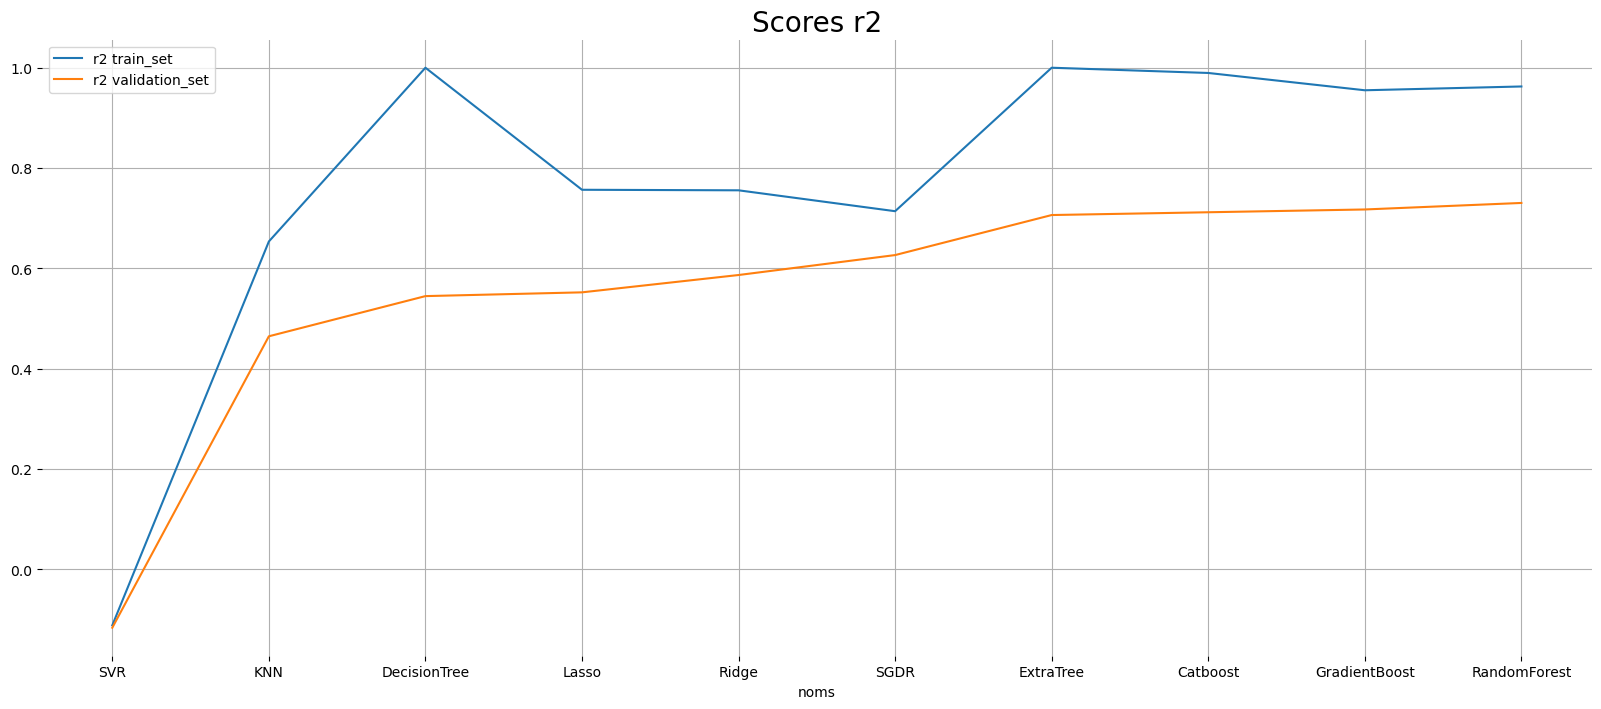

In [29]:
# affichage des scores

scores.sort_values('r2 validation_set',inplace = True)
ax = scores[["r2 train_set","r2 validation_set","noms"]].plot(kind="line", x='noms', figsize=(20,8), title="Scores r2")
ax.legend(["r2 train_set", "r2 validation_set"])

ax.set_xticks(range(len(scores)),scores['noms'])

plt.grid()
ax.title.set_size(20)
plt.box(False)

Certains modèles sont en overfitting.

Il y a un problème avec SVR. Je vais changer les transformers.

In [30]:
preprocessor = make_column_transformer((StandardScaler(), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')
X_train_nrm = preprocessor.fit_transform(X_train,y_train)
resultats = cross_validate(SVR(), X_train_nrm, y_train, cv=5, scoring = 'r2',return_train_score = True,error_score='raise')
resultats

{'fit_time': array([0.03234982, 0.03377056, 0.03171968, 0.04689074, 0.03391385]),
 'score_time': array([0.01606321, 0.01352954, 0.01629734, 0.01562119, 0.01566362]),
 'test_score': array([-0.1116232 , -0.11881355, -0.08098376, -0.10305014, -0.16685522]),
 'train_score': array([-0.10824002, -0.11495666, -0.12056369, -0.11018059, -0.10353829])}

In [31]:
print('résultats sur le train : ',resultats['train_score'].mean())
print('résultats sur le validation : ',resultats['test_score'].mean())


résultats sur le train :  -0.11149585031583178
résultats sur le validation :  -0.11626517202695914


# <a name="6"> Optimisation des modèles

Regardons de plus près les meilleurs estimateurs

## <a name="6a"> Encodage et normalisation

In [32]:
# Je vais utiliser différents transformers

preprocessor0 = make_column_transformer((StandardScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                        remainder = 'passthrough')

preprocessor1 = make_column_transformer((MinMaxScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                       remainder = 'passthrough')

preprocessor2 = make_column_transformer((RobustScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                       remainder = 'passthrough')

preprocessor3 = make_column_transformer((FunctionTransformer(np.log1p), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                       remainder = 'passthrough')

preprocessor4 = make_column_transformer((StandardScaler(), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')

preprocessor5 = make_column_transformer((MinMaxScaler(), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')

preprocessor6 = make_column_transformer((RobustScaler(), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')

preprocessor7 = make_column_transformer((FunctionTransformer(np.log1p), features_num), 
                                      (TargetEncoder(),features_cat),remainder = 'passthrough')



preprocess = [preprocessor0,preprocessor1,preprocessor2,preprocessor3,preprocessor4,preprocessor5,preprocessor6,preprocessor7]

## <a name="6c"> RandomForest

### Hyperparamètres

In [124]:
params = {'randomforestregressor__n_estimators' : [10,50,100],
          'randomforestregressor__criterion' : ['squared_error','friedman_mse','absolute_error','poisson']}


### GridSearchCV

In [125]:
# Testons les hyperparamètres avec le preprocessor0

model = make_pipeline(preprocessor0, RandomForestRegressor(random_state = 0))

grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'randomforestregressor__criterion': ['squared_error',
                                                              'friedman_mse',
                                                              'absolute_error',
                                                              'poisson'],
                         'randomforestregressor__n_estimators': [10, 50, 100]},
             scoring='r2')

In [126]:
grid.best_score_

0.6875429579930875

In [127]:
grid.best_params_

{'randomforestregressor__criterion': 'squared_error',
 'randomforestregressor__n_estimators': 50}

In [38]:
best_esti = grid.best_estimator_
best_esti.score(X_test,y_test)

0.6236262222586489

### Fine tuning

Je vais "jouer" sur l'hyperparamètre n_estimators

In [128]:
%%time

params = {'randomforestregressor__n_estimators' : [30,50,80]}
model = make_pipeline(preprocessor0, RandomForestRegressor(random_state = 0,criterion='squared_error'))
grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train,y_train)

Wall time: 4.73 s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                          'Hospital',
                                                                          'Financial '
                                                                          'Office',
                                                                          'Distribution '
                                                                          'Center',
                                                                          'Parking', ...]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'randomforestregressor__n_estimators': [30, 50, 80]},
             scoring='r2')

In [129]:
grid.best_score_

0.6875429579930875

In [130]:
grid.best_params_

{'randomforestregressor__n_estimators': 50}

In [42]:
cv_res = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,9.719177,0.102311,0.065893,0.006357,1000,{'randomforestregressor__n_estimators': 1000},0.805222,0.615583,0.731777,0.840811,0.666502,0.731979,0.083719,1
2,4.975179,0.086638,0.033752,0.004395,500,{'randomforestregressor__n_estimators': 500},0.802294,0.617451,0.732401,0.842565,0.663804,0.731703,0.083592,2
1,0.974078,0.018779,0.008247,0.007046,100,{'randomforestregressor__n_estimators': 100},0.795912,0.608806,0.740859,0.840304,0.660979,0.729372,0.084946,3
0,0.751361,0.022890,0.009843,0.006295,75,{'randomforestregressor__n_estimators': 75},0.800859,0.596095,0.745076,0.838217,0.659367,0.727923,0.089283,4


In [131]:
grid.best_params_

{'randomforestregressor__n_estimators': 50}

### Sélection des transformers

In [132]:
%%time

# Testons tous les preprocessors avec les meilleurs hyperparamètres

res_randfor_train = []
res_randfor_test = []

for prep in preprocess :
    model = make_pipeline(prep, RandomForestRegressor(random_state = 0, criterion='squared_error',
                                                      n_estimators= 50))
    model.fit(X_train,y_train)
    res_randfor_train.append(model.score(X_train,y_train))
    res_randfor_test.append(model.score(X_test,y_test))

Wall time: 2.67 s


In [133]:
resultats_finaux_rand_forest = pd.DataFrame(data = {'preprocessor' : range(len(res_randfor_train)),
                                                    'resultats train' : res_randfor_train,
                                                    'resultats test' : res_randfor_test })  
resultats_finaux_rand_forest.sort_values('resultats test', ascending = False)

,preprocessor,resultats train,resultats test
3,3,0.959544,0.917986
1,1,0.956695,0.914513
5,5,0.958904,0.913875
7,7,0.959990,0.913611
4,4,0.960001,0.908647
6,6,0.958986,0.908520
2,2,0.957525,0.905656
0,0,0.957870,0.903906


### Meilleur modèle

In [146]:
# scores sur le test set

model_randfor = make_pipeline(preprocessor3,RandomForestRegressor(random_state = 0, criterion='squared_error',n_estimators= 50))
model_randfor.fit(X_train,y_train)
y_pred = model_randfor.predict(X_test)

scores_rand_forest = {'preprocessor' : 'Log et OneHotEncoder', 'R2 test' : round(model.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))),
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_rand_forest

{'preprocessor': 'Log et OneHotEncoder',
 'R2 test': 0.6886,
 'RMSE': 3199031,
 'Mean AE': 1632112,
 'Median AE': 639180}

### Learning curve

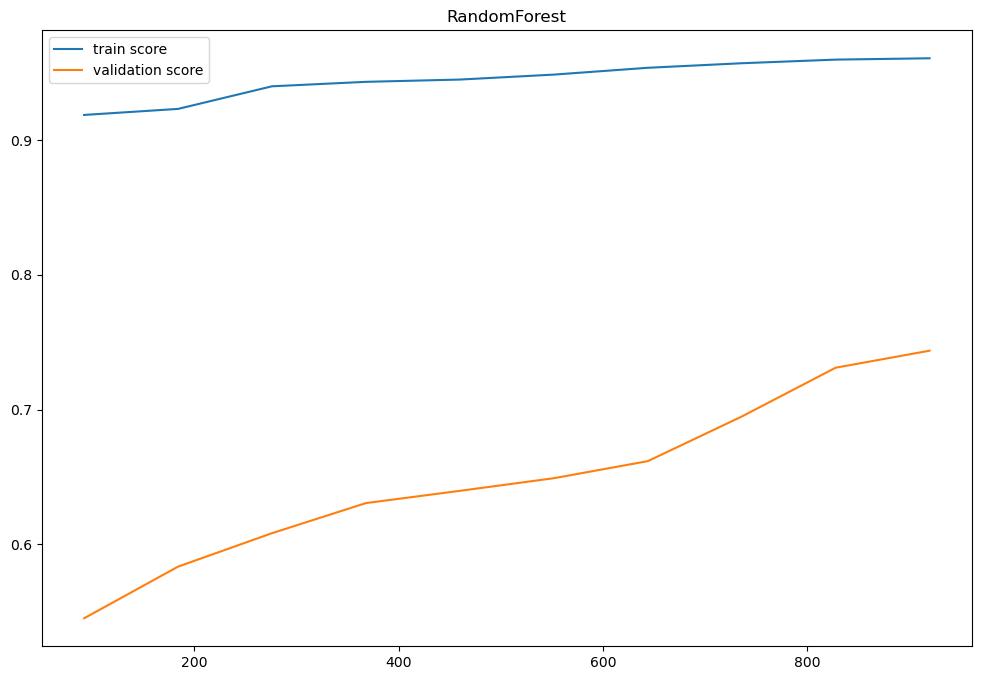

In [47]:

N, train_score, val_score = learning_curve(model_randfor, X_train, y_train,
                                              cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.title('RandomForest')
plt.legend()

### Feature importance

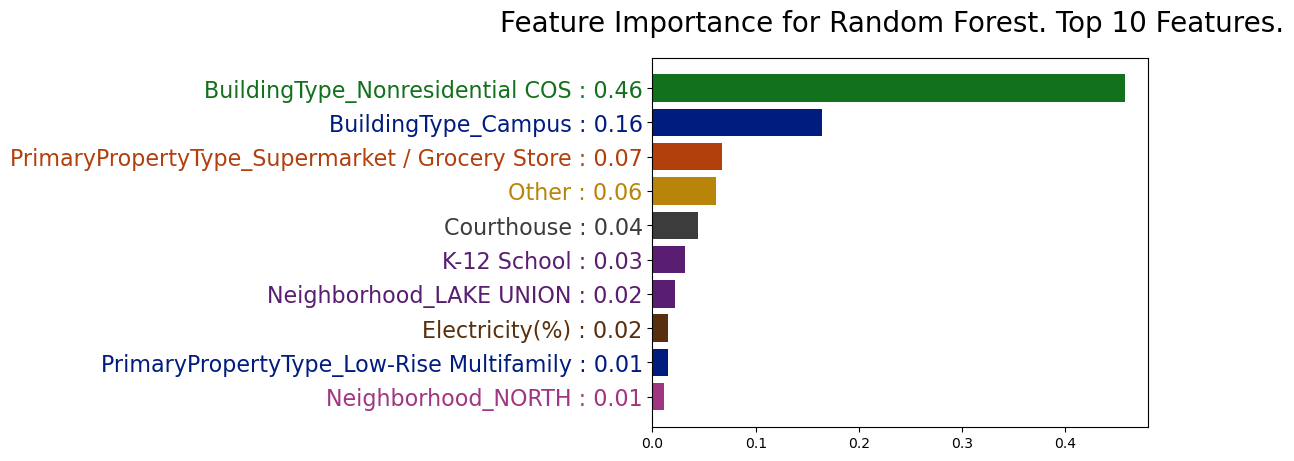

In [48]:
noms_col = preprocessor3.named_transformers_['onehotencoder'].get_feature_names_out(features_cat).tolist() + features_ord + features_num

color_list =  sns.color_palette("dark", len(noms_col)) 
top_x = 10 # number of x most important features to show

model = RandomForestRegressor(random_state = 0, criterion='squared_error',n_estimators= 1000)
X_train_nrm = preprocessor3.fit_transform(X_train,y_train)   
model.fit(X_train_nrm,y_train)

feature_importance = model.feature_importances_
indices = np.argsort(feature_importance)
indices = indices[-top_x:]

plt.barh(range(len(indices)), feature_importance[indices], color= [color_list[indices[i]] for i in range(top_x)],
         align='center')
  
plt.yticks(range(len(indices)), [(noms_col[j] + ' : ' + str(round(feature_importance[j],2))) for j in indices],
           fontweight="normal", fontsize=16) 

for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

plt.suptitle("Feature Importance for Random Forest. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")
plt.show()

## <a name="6b"> GradientBoost

### Hyperparamètres

In [49]:
params = {'gradientboostingregressor__learning_rate': [0.01,0.1],
          'gradientboostingregressor__subsample'    : [1, 0.1],
          'gradientboostingregressor__n_estimators' : [100,1000],
          'gradientboostingregressor__max_depth'    : [3,10]
         }


### GridSearchCV

In [50]:
%%time

# Testons les hyperparamètres avec le preprocessor0

model = make_pipeline(preprocessor0, GradientBoostingRegressor(random_state = 0))

grid = GridSearchCV(model , params, scoring='r2', cv=5  , error_score='raise')
grid.fit(X_train,y_train)

Wall time: 2min 32s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=0))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.01,
                                                                      0.1],
                         'gradientboostingregressor__max_depth': [3, 10],
                         'gradientboostingregressor__n_estimators': [100, 1000],
                         'gradientboostingregressor__subsample': [1, 0.1]},
             scoring='r2')

In [51]:
grid.best_score_

0.7222943415594758

In [52]:
grid.best_params_

{'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__n_estimators': 1000,
 'gradientboostingregressor__subsample': 1}

In [53]:
best_esti = grid.best_estimator_
best_esti.score(X_test,y_test)

0.6815979097486577

### Fine tuning

In [54]:
params = {'gradientboostingregressor__learning_rate': [0.1,1],
          'gradientboostingregressor__subsample'    : [1,0.5],
          'gradientboostingregressor__n_estimators' : [1000],
          'gradientboostingregressor__max_depth'    : [1,3,7]
         }

In [55]:
%%time

# Testons les hyperparamètres avec le preprocessor0

model = make_pipeline(preprocessor0, GradientBoostingRegressor(random_state = 0))

grid = GridSearchCV(model , params, scoring='r2', cv=5  , error_score='raise')
grid.fit(X_train,y_train)

Wall time: 2min 13s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=0))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.1, 1],
                         'gradientboostingregressor__max_depth': [1, 3, 7],
                         'gradientboostingregressor__n_estimators': [1000],
                         'gradientboostingregressor__subsample': [1, 0.5]},
             scoring='r2')

In [56]:
resultats_cv = pd.DataFrame(grid.cv_results_)
resultats_cv.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingregressor__learning_rate,param_gradientboostingregressor__max_depth,param_gradientboostingregressor__n_estimators,param_gradientboostingregressor__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,5.575027,0.026374,0.009372,0.007652,0.1,7,1000,1,{'gradientboostingregressor__learning_rate': 0...,0.804032,0.552878,0.860478,0.835739,0.703764,0.751378,0.112660,1
5,3.013927,0.009796,0.009157,0.007486,0.1,7,1000,0.5,{'gradientboostingregressor__learning_rate': 0...,0.819864,0.653805,0.746876,0.848418,0.671721,0.748137,0.077383,2
3,1.509056,0.017774,0.006035,0.005345,0.1,3,1000,0.5,{'gradientboostingregressor__learning_rate': 0...,0.772519,0.668646,0.801272,0.807621,0.570983,0.724208,0.091428,3
2,2.603434,0.012506,0.001712,0.002358,0.1,3,1000,1,{'gradientboostingregressor__learning_rate': 0...,0.785741,0.607024,0.763618,0.832595,0.622493,0.722294,0.090716,4
0,1.034267,0.004357,0.000798,0.001597,0.1,1,1000,1,{'gradientboostingregressor__learning_rate': 0...,0.739997,0.672244,0.624682,0.686232,0.630563,0.670743,0.041891,5


In [57]:
grid.best_params_

{'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__max_depth': 7,
 'gradientboostingregressor__n_estimators': 1000,
 'gradientboostingregressor__subsample': 1}

### Sélection des preprocessors

In [135]:
# Testons tous les preprocessors avec les meilleurs hyperparamètres

res_gradboost_train = []
res_gradboost_test = []

for prep in preprocess :
    model = make_pipeline(prep, GradientBoostingRegressor(random_state = 0, learning_rate = 0.1, max_depth = 7,
                                                      n_estimators= 1000  , subsample= 1))
    model.fit(X_train,y_train)
    res_gradboost_train.append(model.score(X_train,y_train))
    res_gradboost_test.append(model.score(X_test,y_test))

In [136]:
resultats_finaux_gradboost = pd.DataFrame(data = {'preprocessor' : range(len(res_gradboost_train)),
                                                    'resultats train' : res_gradboost_train,
                                                    'resultats test' : res_gradboost_test })  
resultats_finaux_gradboost.sort_values('resultats test',ascending=False)

,preprocessor,resultats train,resultats test
0,0,1.0,0.790413
4,4,1.0,0.769950
3,3,1.0,0.762170
1,1,1.0,0.759920
2,2,1.0,0.757599
6,6,1.0,0.754588
5,5,1.0,0.749777
7,7,1.0,0.749119


le preprocessor0 donne le meilleur score

### Meilleur modèle

In [147]:
# scores sur le test set

model_gradboost = make_pipeline(preprocessor0,GradientBoostingRegressor(random_state = 0, learning_rate = 0.1, max_depth = 7,
                                                      n_estimators= 1000  , subsample= 1))
model_gradboost.fit(X_train,y_train)
y_pred = model_gradboost.predict(X_test)

scores_gradboost = {'preprocessor' : 'StandardScaler et OneHotEncoder', 'R2 test' : round(model.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))),
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_gradboost

{'preprocessor': 'StandardScaler et OneHotEncoder',
 'R2 test': 0.6886,
 'RMSE': 5113956,
 'Mean AE': 1992618,
 'Median AE': 565904}

### Learning curve

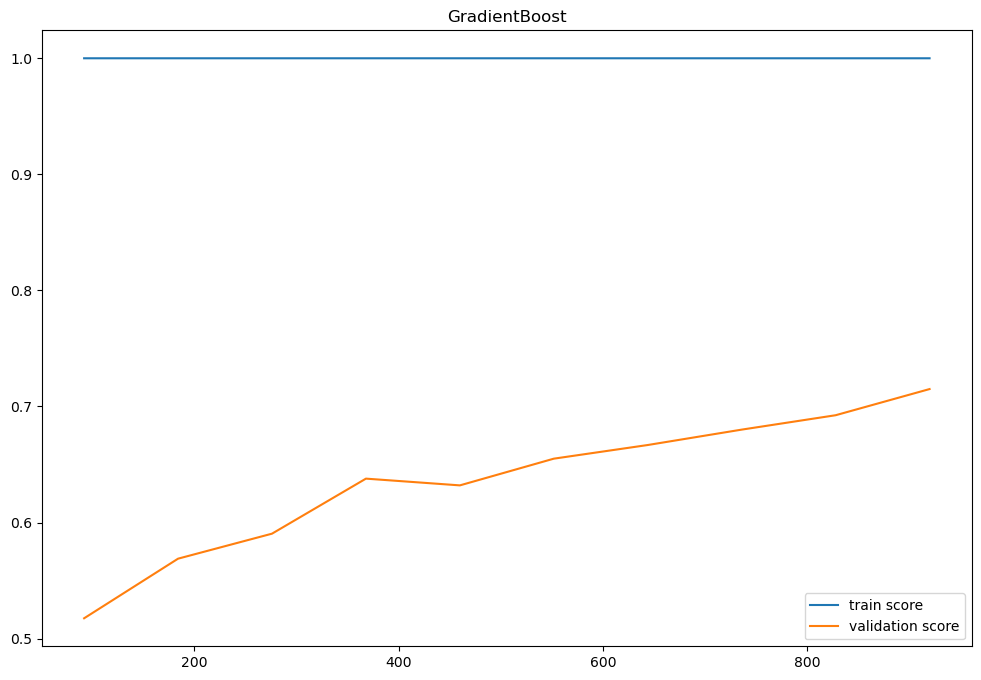

In [61]:

N, train_score, val_score = learning_curve(model_gradboost, X_train, y_train,
                                              cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.title('GradientBoost')
plt.legend()

### Feature importance

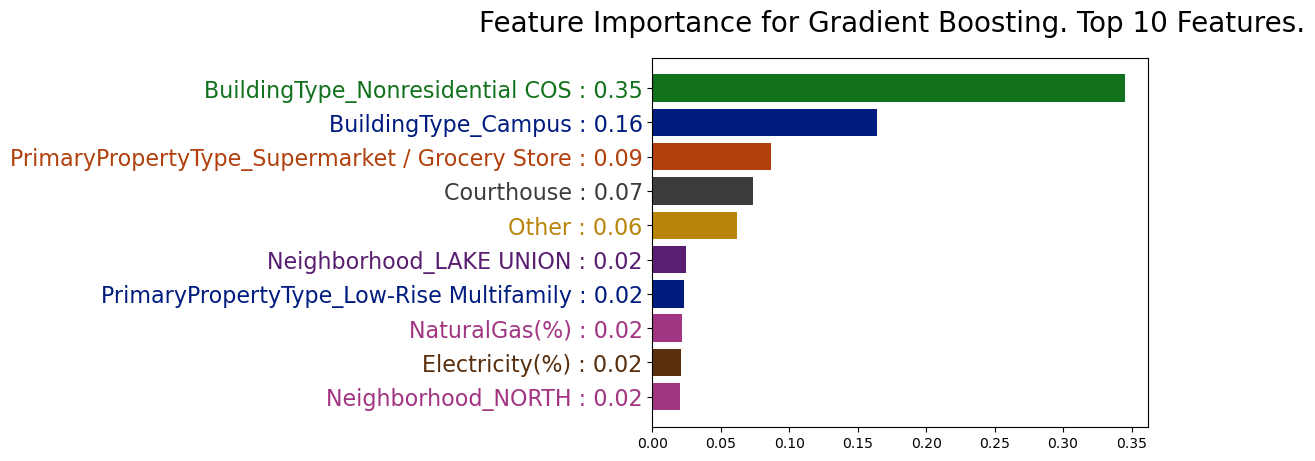

In [62]:
noms_col = preprocessor3.named_transformers_['onehotencoder'].get_feature_names_out(features_cat).tolist() + features_ord + features_num

color_list =  sns.color_palette("dark", len(noms_col)) 
top_x = 10 # number of x most important features to show

model = GradientBoostingRegressor(random_state = 0, learning_rate = 0.1,
                                  max_depth = 7,n_estimators= 1000 , subsample=0.5)
X_train_nrm = preprocessor3.fit_transform(X_train)   
model.fit(X_train_nrm,y_train)

feature_importance = model.feature_importances_
indices = np.argsort(feature_importance)
indices = indices[-top_x:]

plt.barh(range(len(indices)), feature_importance[indices], color= [color_list[indices[i]] for i in range(top_x)],
         align='center')

plt.yticks(range(len(indices)), [noms_col[j] + ' : ' + str(round(feature_importance[j],2)) for j in indices],
           fontweight="normal", fontsize=16) 

for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

plt.suptitle("Feature Importance for Gradient Boosting. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")
plt.show()

## <a name="6d"> SGDRegressor

### Hyperparamètres

In [63]:
params = {'loss' : ['squared_epsilon_insensitive','huber','squared_error','epsilon_insensitive'],
          'alpha' : 10.0**-np.arange(1,7)}

### GridSearchCV

In [64]:
model = SGDRegressor(random_state = 0)
X_train_nrm = preprocessor0.fit_transform(X_train)

grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train_nrm,y_train)

GridSearchCV(cv=5, error_score='raise', estimator=SGDRegressor(random_state=0),
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'loss': ['squared_epsilon_insensitive', 'huber',
                                  'squared_error', 'epsilon_insensitive']},
             scoring='r2')

In [65]:
grid.best_score_

0.6478832051514652

In [66]:
grid.best_params_

{'alpha': 0.1, 'loss': 'squared_error'}

In [67]:
cv_res = pd.DataFrame(grid.cv_results_)
cv_res.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.005302,0.002582,0.000000,0.000000,0.1,squared_error,"{'alpha': 0.1, 'loss': 'squared_error'}",0.723825,0.678515,0.514215,0.684019,0.638842,0.647883,0.072056,1
6,0.006249,0.007653,0.000000,0.000000,0.01,squared_error,"{'alpha': 0.01, 'loss': 'squared_error'}",0.701796,0.687646,0.540960,0.654050,0.635847,0.644060,0.056622,2
10,0.006853,0.008556,0.000000,0.000000,0.001,squared_error,"{'alpha': 0.001, 'loss': 'squared_error'}",0.652127,0.687887,0.541654,0.648468,0.634458,0.632919,0.048916,3
14,0.006326,0.002105,0.000399,0.000489,0.0001,squared_error,"{'alpha': 0.0001, 'loss': 'squared_error'}",0.651505,0.687900,0.541717,0.617314,0.634298,0.626547,0.048432,4
18,0.006183,0.001934,0.000399,0.000489,0.00001,squared_error,"{'alpha': 1e-05, 'loss': 'squared_error'}",0.651442,0.687901,0.541724,0.617264,0.634282,0.626523,0.048425,5


### Fine tuning

In [68]:
params = {'loss' : ['squared_error'],'alpha' : [0,0.1,0.2,0.8]}

In [69]:
model = SGDRegressor(random_state = 0)
X_train_nrm = preprocessor0.fit_transform(X_train)

grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train_nrm,y_train)

GridSearchCV(cv=5, error_score='raise', estimator=SGDRegressor(random_state=0),
             param_grid={'alpha': [0, 0.1, 0.2, 0.8],
                         'loss': ['squared_error']},
             scoring='r2')

In [70]:
grid.best_params_

{'alpha': 0.1, 'loss': 'squared_error'}

In [71]:
params = {'loss' : ['squared_error'],'alpha' : [0.05,0.1,0.15]}

In [72]:
model = SGDRegressor(random_state = 0)
X_train_nrm = preprocessor0.fit_transform(X_train)

grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train_nrm,y_train)

GridSearchCV(cv=5, error_score='raise', estimator=SGDRegressor(random_state=0),
             param_grid={'alpha': [0.05, 0.1, 0.15], 'loss': ['squared_error']},
             scoring='r2')

In [73]:
grid.best_params_

{'alpha': 0.1, 'loss': 'squared_error'}

### Sélection des transformers

In [140]:
# Testons tous les preprocessors avec les meilleurs hyperparamètres

res_sgdr_train = []
res_sgdr_test = []

for prep in preprocess :
    model = make_pipeline(prep, SGDRegressor(random_state=0,loss = 'squared_error',alpha=0.1))
    model.fit(X_train,y_train)
    res_sgdr_train.append(model.score(X_train,y_train))
    res_sgdr_test.append(model.score(X_test,y_test))

In [141]:
resultats_finaux_sgdr = pd.DataFrame(data = {'preprocessor' : range(len(res_sgdr_train)),
                                            'resultats train' : res_sgdr_train,
                                            'resultats test' : res_sgdr_test })  
resultats_finaux_sgdr.sort_values('resultats test',ascending=False)

,preprocessor,resultats train,resultats test
3,3,-1.293459e+09,-1.132463e+09
0,0,-9.195229e+09,-1.638450e+10
1,1,-4.398964e+10,-7.406812e+10
2,2,-6.177344e+10,-1.006583e+11
7,7,-5.675088e+31,-7.297693e+31
4,4,-5.675088e+31,-7.297693e+31
5,5,-5.675088e+31,-7.297693e+31
6,6,-5.675088e+31,-7.297693e+31


### Meilleur modèle

In [148]:
# scores sur le test set

model_sgdr = make_pipeline(preprocessor0,SGDRegressor(random_state=0,loss = 'squared_error',alpha=0.15))
model_sgdr.fit(X_train,y_train)
y_pred = model_sgdr.predict(X_test)

scores_sgdr = {'preprocessor' : 'StandardScaler et OneHotEncoder', 'R2 test' : res_sgdr_test[0],
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_sgdr

{'preprocessor': 'StandardScaler et OneHotEncoder',
 'R2 test': -16384495466.30232,
 'RMSE': 2522818894843,
 'Mean AE': 2332477611523,
 'Median AE': 2571576487948}

### Learning curve

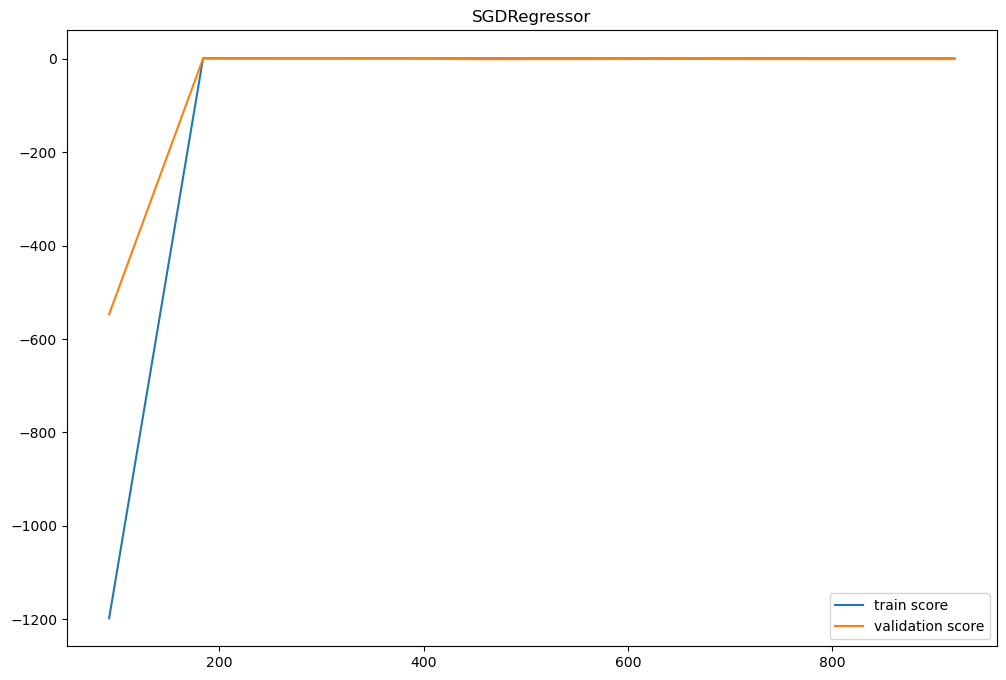

In [77]:

N, train_score, val_score = learning_curve(model_sgdr, X_train, y_train,
                                              cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.title('SGDRegressor')
plt.legend()

### Feature importance

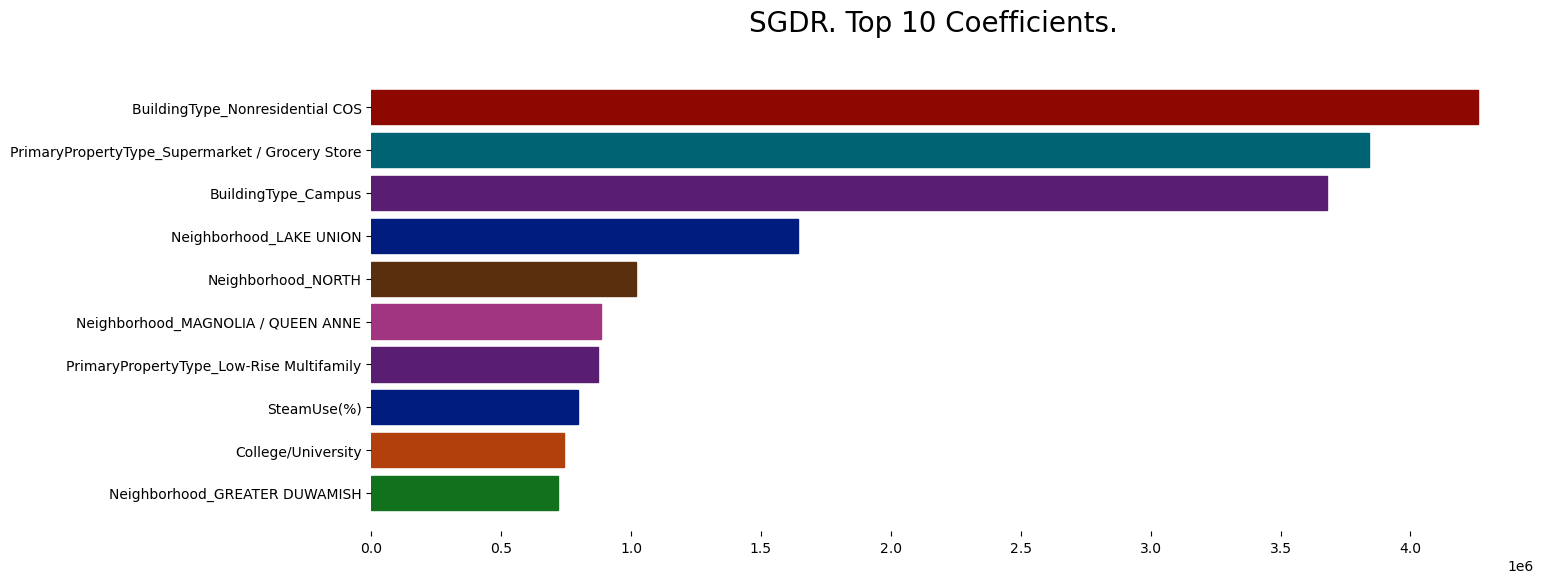

In [78]:
plt.figure(figsize=(15,6))

noms_col = preprocessor0.named_transformers_['onehotencoder'].get_feature_names_out(features_cat).tolist() + features_ord + features_num

model = SGDRegressor(random_state = 0, loss = 'squared_error', alpha = 0.15)
X_train_nrm = preprocessor0.fit_transform(X_train,y_train)
model.fit(X_train_nrm,y_train)
sgdr_coeff = model.coef_

color_list =  sns.color_palette("dark", len(noms_col)) 
top_x = 10

idx = np.argsort(np.abs(sgdr_coeff))[::-1][:top_x][::-1]
lasso_ax = plt.barh([noms_col[i] for i in idx], sgdr_coeff[idx])

for i,bar in enumerate(lasso_ax):
    bar.set_color(color_list[idx[:top_x][::-1][i]])
    plt.box(False) 
sgdr_title = plt.suptitle("SGDR. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")


## <a name="6e"> Ridge

### Hyperparamètres

In [79]:
params = {'ridge__alpha' : 10.0**np.arange(-8,5)}

### GridSearchCV

In [80]:
# Testons les hyperparamètres avec le preprocessor0

model = make_pipeline(preprocessor0, Ridge(random_state = 0))

grid = GridSearchCV(model , params, scoring='r2', cv=5, error_score='raise')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'PropertyGFABuilding(s)',
                                                                          'Hotel',
                                                                          'Police '
                                                                          'Station',
                                                                          'Other '
                                                                          '- '
                                                                          'Entertainment/Public '
                                                                          'Assembly',
                                                                          'Library',
                                                                          'Fitness '
                                                                          'Center/Health '
                                                                          'Club...
                                                                          'Distribution '
                                                                          'Center',
                                                                          'Parking', ...]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'YearBuilt'])])),
                                       ('ridge', Ridge(random_state=0))]),
             param_grid={'ridge__alpha': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])},
             scoring='r2')

In [81]:
grid.best_score_

0.5520549928962861

In [82]:
grid.best_params_

{'ridge__alpha': 0.01}

In [83]:
best_esti = grid.best_estimator_
best_esti.score(X_test,y_test)

0.6622598008585601

### Sélection du transformer

In [143]:
# Testons tous les preprocessors avec les meilleurs hyperparamètres

res_ridge_train = []
res_ridge_test = []

for ind,prep in enumerate(preprocess) :
    model = make_pipeline(prep, Ridge(random_state = 0, alpha = 0.01))
    model.fit(X_train,y_train)
    res_ridge_train.append(model.score(X_train,y_train))
    res_ridge_test.append(model.score(X_test,y_test))

In [144]:
resultats_finaux_ridge = pd.DataFrame(data = {'preprocessor' : range(len(res_ridge_train)),
                                            'resultats train' : res_ridge_train,
                                            'resultats test' : res_ridge_test })  
resultats_finaux_ridge.sort_values('resultats test',ascending=False)

,preprocessor,resultats train,resultats test
6,6,0.817397,0.795364
4,4,0.817397,0.795351
5,5,0.817388,0.795254
1,1,0.829313,0.727296
2,2,0.829481,0.723356
0,0,0.829481,0.723323
7,7,0.796383,0.688585
3,3,0.814143,0.659625


### Meilleur modèle

In [149]:
# scores sur le test set

model_ridge = make_pipeline(preprocessor5,Ridge(random_state = 0, alpha = 1e-07))
model_ridge.fit(X_train,y_train)
y_pred = model_ridge.predict(X_test)

scores_ridge = {'preprocessor' : 'MinMax et TargetEncoder', 'R2 test' : round(model.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}
scores_ridge

{'preprocessor': 'MinMax et TargetEncoder',
 'R2 test': 0.6886,
 'RMSE': 5053308,
 'Mean AE': 2499456,
 'Median AE': 1337714}

### Learning curve

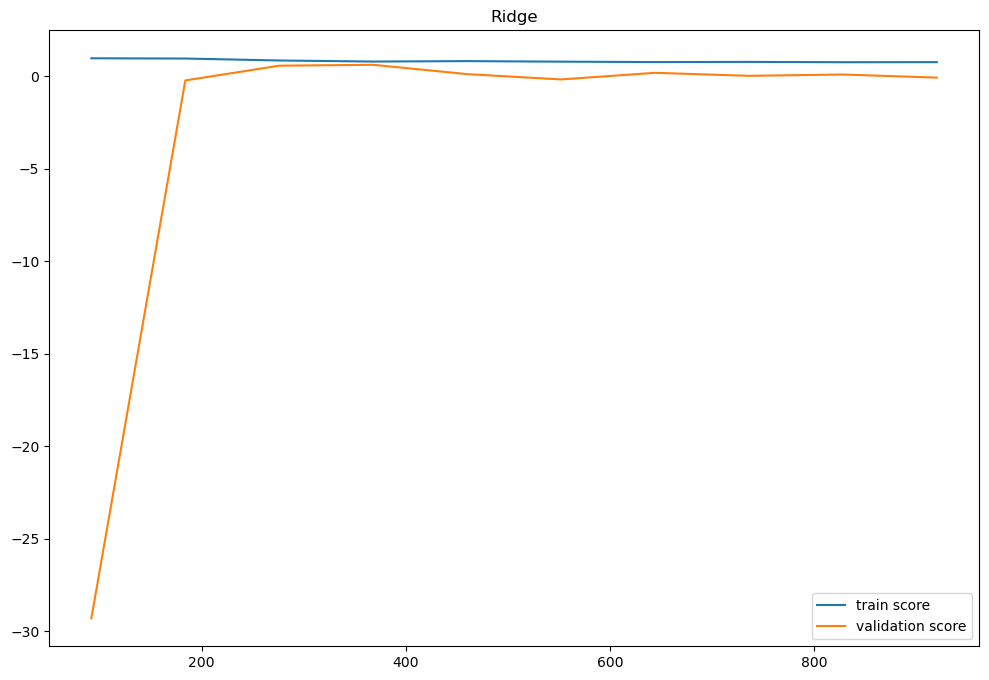

In [87]:

N, train_score, val_score = learning_curve(model_ridge, X_train, y_train,
                                              cv=4, scoring='r2',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.title('Ridge')
plt.legend()

In [88]:
X_train.columns[1]

'PrimaryPropertyType'

In [89]:
X_train_nrm = preprocessor4.fit_transform(X_train,y_train)
#noms_col = preprocessor4.named_transformers_['targetencoder'].get_feature_names_out(features_cat).tolist() + features_ord + features_num
len(X_train_nrm[1])

76

### Feature importance

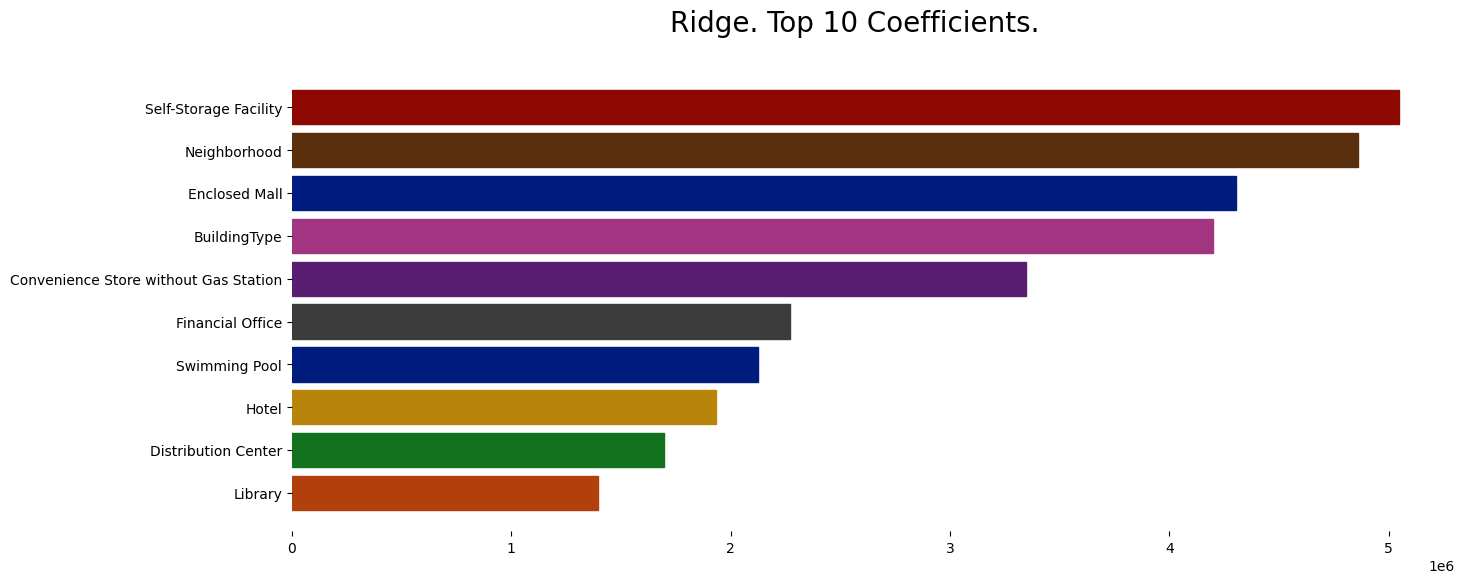

In [90]:
plt.figure(figsize=(15,6))

model = Ridge(random_state = 0, alpha = 1e-07)
X_train_nrm = preprocessor4.fit_transform(X_train,y_train)
model.fit(X_train_nrm,y_train)
ridge_coeff = model.coef_

color_list =  sns.color_palette("dark", len(X_train.columns)) 
top_x = 10

idx = np.argsort(np.abs(ridge_coeff))[::-1][:top_x][::-1]
ridge_ax = plt.barh([X_train.columns[i] for i in idx], ridge_coeff[idx])

for i,bar in enumerate(ridge_ax):
    bar.set_color(color_list[idx[:top_x][::-1][i]])
    plt.box(False) 
ridge_title = plt.suptitle("Ridge. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")


# <a name="7"> Influence de l'EnergyStarScore

In [150]:
# j'ajoute la variable ENERGYSTARScore aux features

features_num.append('ENERGYSTARScore')

In [151]:
data.isna().mean().sort_values()

BuildingType               0.000000
Performing Arts            0.000000
Fire Station               0.000000
Other - Public Services    0.000000
Lifestyle Center           0.000000
                             ...   
Automobile Dealership      0.000000
College/University         0.000000
Courthouse                 0.000000
NaturalGas(%)              0.000000
ENERGYSTARScore            0.356584
Length: 79, dtype: float64

In [152]:
# je supprime les lignes sans ESS

data_reduit = data.dropna()

In [153]:
data_reduit.isna().mean().sort_values()

BuildingType               0.0
Performing Arts            0.0
Fire Station               0.0
Other - Public Services    0.0
Lifestyle Center           0.0
                          ... 
Office                     0.0
Automobile Dealership      0.0
College/University         0.0
Senior Care Community      0.0
NaturalGas(%)              0.0
Length: 79, dtype: float64

## Avec ESS

In [154]:
X = data_reduit[features_cat + features_ord + features_num]
y = data_reduit['SiteEnergyUse(kBtu)']

In [96]:
# transformer

preprocessor = make_column_transformer((StandardScaler(), features_num), 
                                      (OneHotEncoder(handle_unknown = 'ignore',sparse_output=False),features_cat),
                                      remainder = 'passthrough')


In [97]:
# Estimateurs

est1 = neighbors.KNeighborsRegressor()
est2 = SGDRegressor(random_state = 0)
est3 = Ridge(random_state = 0)
est4 = Lasso(random_state = 0)
est5 = DecisionTreeRegressor(random_state = 0)
est6 = RandomForestRegressor(random_state = 0)
est7 = SVR()
est8 = CatBoostRegressor(random_state = 0)
est9 = GradientBoostingRegressor(random_state = 0)
est10 = ExtraTreesRegressor(random_state = 0)

models = {'KNN' : est1, 'SGDR' : est2, 'Ridge' : est3, 'Lasso' : est4, 'DecisionTree' : est5,
          'Randomforest' : est6, 'SVR' : est7,'Catboost' : est8, 'GradientBoost' : est9,'ExtraTree' : est10}

In [98]:
# Normalisation et encodage

X_nrm = preprocessor.fit_transform(X)

In [99]:
# évaluation des modèles

resultats = {}
resultats_train = []
resultats_test = []

for cle, esti in models.items() :
    resultats[cle] = (cross_validate(esti, X_nrm, y, cv=5, scoring = 'r2',return_train_score = True,error_score='raise'))
    resultats_train.append(resultats[cle]['train_score'].mean())
    resultats_test.append(resultats[cle]['test_score'].mean())

scores = pd.DataFrame(data={'r2 train_set_avec_ESS' : resultats_train,'r2 testset_avec_ESS' :resultats_test},index=models.keys())
scores

Learning rate set to 0.039438
0:	learn: 10400834.6032580	total: 1.42ms	remaining: 1.42s
1:	learn: 10272381.9279585	total: 2.53ms	remaining: 1.26s
2:	learn: 10106788.9431047	total: 3.61ms	remaining: 1.2s
3:	learn: 9966246.7580885	total: 4.69ms	remaining: 1.17s
4:	learn: 9845037.9183274	total: 5.66ms	remaining: 1.13s
5:	learn: 9700432.1992108	total: 6.53ms	remaining: 1.08s
6:	learn: 9569111.3399863	total: 7.4ms	remaining: 1.05s
7:	learn: 9428823.7738796	total: 8.34ms	remaining: 1.03s
8:	learn: 9313185.8228628	total: 9.28ms	remaining: 1.02s
9:	learn: 9188752.3727507	total: 10.3ms	remaining: 1.01s
10:	learn: 9076412.4791723	total: 11.2ms	remaining: 1.01s
11:	learn: 8942320.9479380	total: 12.1ms	remaining: 1s
12:	learn: 8836496.8246710	total: 13.1ms	remaining: 998ms
13:	learn: 8742959.1779301	total: 14ms	remaining: 990ms
14:	learn: 8627081.3113149	total: 14.9ms	remaining: 981ms
15:	learn: 8522489.5396507	total: 15.8ms	remaining: 972ms
16:	learn: 8407246.8707807	total: 16.7ms	remaining: 964m

213:	learn: 2389711.4723360	total: 189ms	remaining: 694ms
214:	learn: 2385079.2907247	total: 190ms	remaining: 694ms
215:	learn: 2381982.0608847	total: 191ms	remaining: 693ms
216:	learn: 2377722.5653800	total: 192ms	remaining: 692ms
217:	learn: 2373159.9448860	total: 193ms	remaining: 691ms
218:	learn: 2362677.0447693	total: 193ms	remaining: 690ms
219:	learn: 2341769.0763160	total: 194ms	remaining: 689ms
220:	learn: 2338134.2995746	total: 195ms	remaining: 689ms
221:	learn: 2335088.1775026	total: 196ms	remaining: 688ms
222:	learn: 2317552.0127139	total: 197ms	remaining: 687ms
223:	learn: 2313315.8295899	total: 198ms	remaining: 686ms
224:	learn: 2299790.8090911	total: 199ms	remaining: 686ms
225:	learn: 2295605.9617652	total: 200ms	remaining: 685ms
226:	learn: 2280648.7369412	total: 201ms	remaining: 684ms
227:	learn: 2268626.3215351	total: 202ms	remaining: 684ms
228:	learn: 2264628.4106903	total: 203ms	remaining: 683ms
229:	learn: 2260503.8135960	total: 204ms	remaining: 682ms
230:	learn: 22

418:	learn: 1238619.9965602	total: 378ms	remaining: 524ms
419:	learn: 1237167.4258769	total: 379ms	remaining: 523ms
420:	learn: 1233034.7993759	total: 380ms	remaining: 523ms
421:	learn: 1229433.0016078	total: 381ms	remaining: 522ms
422:	learn: 1228194.0104597	total: 382ms	remaining: 521ms
423:	learn: 1223523.4560157	total: 383ms	remaining: 520ms
424:	learn: 1219708.3206575	total: 384ms	remaining: 519ms
425:	learn: 1216142.5873540	total: 385ms	remaining: 519ms
426:	learn: 1212034.9777339	total: 386ms	remaining: 518ms
427:	learn: 1208221.0262697	total: 387ms	remaining: 517ms
428:	learn: 1203756.1081935	total: 388ms	remaining: 516ms
429:	learn: 1202938.0806628	total: 389ms	remaining: 515ms
430:	learn: 1200133.5886657	total: 390ms	remaining: 514ms
431:	learn: 1196868.4173053	total: 391ms	remaining: 513ms
432:	learn: 1193349.4194606	total: 391ms	remaining: 513ms
433:	learn: 1192769.4054849	total: 393ms	remaining: 512ms
434:	learn: 1188979.1206420	total: 394ms	remaining: 511ms
435:	learn: 11

640:	learn: 815570.7868423	total: 578ms	remaining: 323ms
641:	learn: 815364.9028435	total: 579ms	remaining: 323ms
642:	learn: 815163.9083120	total: 580ms	remaining: 322ms
643:	learn: 814981.6949446	total: 580ms	remaining: 321ms
644:	learn: 814737.7915296	total: 581ms	remaining: 320ms
645:	learn: 814562.6711090	total: 582ms	remaining: 319ms
646:	learn: 813922.4264848	total: 583ms	remaining: 318ms
647:	learn: 813687.7169727	total: 584ms	remaining: 317ms
648:	learn: 813454.3112088	total: 585ms	remaining: 317ms
649:	learn: 813226.9214018	total: 586ms	remaining: 316ms
650:	learn: 812440.6253767	total: 587ms	remaining: 315ms
651:	learn: 812283.6610445	total: 588ms	remaining: 314ms
652:	learn: 810165.1858862	total: 589ms	remaining: 313ms
653:	learn: 808566.9415447	total: 590ms	remaining: 312ms
654:	learn: 807981.4675283	total: 591ms	remaining: 311ms
655:	learn: 806484.7329214	total: 592ms	remaining: 311ms
656:	learn: 804489.9502705	total: 597ms	remaining: 312ms
657:	learn: 804150.8334044	tota

840:	learn: 620328.2092127	total: 767ms	remaining: 145ms
841:	learn: 620167.7796513	total: 768ms	remaining: 144ms
842:	learn: 619494.5988030	total: 769ms	remaining: 143ms
843:	learn: 619319.1840753	total: 770ms	remaining: 142ms
844:	learn: 619045.1112164	total: 771ms	remaining: 141ms
845:	learn: 618467.6096816	total: 772ms	remaining: 140ms
846:	learn: 617830.2262573	total: 773ms	remaining: 140ms
847:	learn: 617470.4955737	total: 774ms	remaining: 139ms
848:	learn: 616565.3162474	total: 775ms	remaining: 138ms
849:	learn: 615564.9014347	total: 776ms	remaining: 137ms
850:	learn: 615005.8407057	total: 776ms	remaining: 136ms
851:	learn: 614315.4380699	total: 777ms	remaining: 135ms
852:	learn: 614001.7015709	total: 778ms	remaining: 134ms
853:	learn: 613178.2254175	total: 779ms	remaining: 133ms
854:	learn: 611805.6253575	total: 780ms	remaining: 132ms
855:	learn: 611368.5110072	total: 781ms	remaining: 131ms
856:	learn: 610288.7982377	total: 782ms	remaining: 131ms
857:	learn: 609119.0216291	tota

Learning rate set to 0.039438
0:	learn: 13572828.6177962	total: 2.64ms	remaining: 2.64s
1:	learn: 13325979.6335302	total: 3.57ms	remaining: 1.78s
2:	learn: 13072164.3365669	total: 4.47ms	remaining: 1.48s
3:	learn: 12808700.8681135	total: 5.38ms	remaining: 1.34s
4:	learn: 12563107.2009653	total: 6.29ms	remaining: 1.25s
5:	learn: 12340858.3850073	total: 7.17ms	remaining: 1.19s
6:	learn: 12110835.5102767	total: 8.06ms	remaining: 1.14s
7:	learn: 11917663.6243878	total: 8.96ms	remaining: 1.11s
8:	learn: 11710816.6673091	total: 9.86ms	remaining: 1.08s
9:	learn: 11498631.5947874	total: 10.8ms	remaining: 1.06s
10:	learn: 11314932.9655855	total: 11.7ms	remaining: 1.05s
11:	learn: 11119270.0227585	total: 12.6ms	remaining: 1.03s
12:	learn: 10920662.4765517	total: 13.5ms	remaining: 1.02s
13:	learn: 10734295.3119431	total: 14.4ms	remaining: 1.01s
14:	learn: 10536251.5355276	total: 15.3ms	remaining: 1.01s
15:	learn: 10370407.3641425	total: 16.2ms	remaining: 999ms
16:	learn: 10203165.4512085	total: 1

213:	learn: 2576125.8438252	total: 192ms	remaining: 707ms
214:	learn: 2563964.2672311	total: 194ms	remaining: 707ms
215:	learn: 2546995.7314633	total: 195ms	remaining: 707ms
216:	learn: 2532912.4899736	total: 196ms	remaining: 706ms
217:	learn: 2522766.6356758	total: 197ms	remaining: 706ms
218:	learn: 2518403.5074975	total: 198ms	remaining: 705ms
219:	learn: 2508497.6928952	total: 199ms	remaining: 704ms
220:	learn: 2504106.0810370	total: 200ms	remaining: 704ms
221:	learn: 2500828.0948188	total: 201ms	remaining: 703ms
222:	learn: 2485225.1438868	total: 202ms	remaining: 703ms
223:	learn: 2474919.7571667	total: 203ms	remaining: 702ms
224:	learn: 2463568.2356166	total: 204ms	remaining: 702ms
225:	learn: 2457305.1408494	total: 205ms	remaining: 701ms
226:	learn: 2445620.4579404	total: 206ms	remaining: 701ms
227:	learn: 2441491.1934537	total: 207ms	remaining: 701ms
228:	learn: 2427319.8226250	total: 208ms	remaining: 701ms
229:	learn: 2414608.8719217	total: 209ms	remaining: 700ms
230:	learn: 24

428:	learn: 1445652.9938373	total: 390ms	remaining: 519ms
429:	learn: 1440565.0480201	total: 391ms	remaining: 518ms
430:	learn: 1439127.2935522	total: 392ms	remaining: 517ms
431:	learn: 1438494.4014410	total: 393ms	remaining: 516ms
432:	learn: 1437876.6571649	total: 393ms	remaining: 515ms
433:	learn: 1436476.2885009	total: 394ms	remaining: 514ms
434:	learn: 1435104.5224289	total: 395ms	remaining: 513ms
435:	learn: 1431874.4340292	total: 396ms	remaining: 513ms
436:	learn: 1428998.2248815	total: 397ms	remaining: 512ms
437:	learn: 1428266.6078683	total: 398ms	remaining: 511ms
438:	learn: 1422253.1041642	total: 399ms	remaining: 510ms
439:	learn: 1418411.3484077	total: 400ms	remaining: 509ms
440:	learn: 1415055.0531212	total: 401ms	remaining: 508ms
441:	learn: 1413898.6187787	total: 402ms	remaining: 507ms
442:	learn: 1412916.3507165	total: 403ms	remaining: 506ms
443:	learn: 1412259.3257016	total: 403ms	remaining: 505ms
444:	learn: 1410940.4687540	total: 404ms	remaining: 504ms
445:	learn: 14

624:	learn: 1025079.4169978	total: 587ms	remaining: 352ms
625:	learn: 1023246.1790620	total: 588ms	remaining: 351ms
626:	learn: 1021868.6193211	total: 589ms	remaining: 350ms
627:	learn: 1020793.0657055	total: 590ms	remaining: 349ms
628:	learn: 1017272.0077365	total: 591ms	remaining: 348ms
629:	learn: 1014005.9735448	total: 592ms	remaining: 347ms
630:	learn: 1011719.0611501	total: 592ms	remaining: 346ms
631:	learn: 1010213.6726900	total: 593ms	remaining: 346ms
632:	learn: 1008837.6952479	total: 594ms	remaining: 345ms
633:	learn: 1007816.1650177	total: 595ms	remaining: 344ms
634:	learn: 1005971.9650558	total: 596ms	remaining: 343ms
635:	learn: 1004265.2027994	total: 597ms	remaining: 342ms
636:	learn: 1003315.9459429	total: 598ms	remaining: 341ms
637:	learn: 1002550.3457703	total: 599ms	remaining: 340ms
638:	learn: 1001351.1717528	total: 600ms	remaining: 339ms
639:	learn: 998977.8950752	total: 601ms	remaining: 338ms
640:	learn: 996245.4071449	total: 602ms	remaining: 337ms
641:	learn: 9940

835:	learn: 747009.1803984	total: 779ms	remaining: 153ms
836:	learn: 744774.1468490	total: 780ms	remaining: 152ms
837:	learn: 743115.4863739	total: 781ms	remaining: 151ms
838:	learn: 742147.2509917	total: 782ms	remaining: 150ms
839:	learn: 740977.8918951	total: 783ms	remaining: 149ms
840:	learn: 740078.6181318	total: 784ms	remaining: 148ms
841:	learn: 738731.6536398	total: 785ms	remaining: 147ms
842:	learn: 737556.2549831	total: 786ms	remaining: 146ms
843:	learn: 736587.9216189	total: 787ms	remaining: 145ms
844:	learn: 735344.7051241	total: 788ms	remaining: 144ms
845:	learn: 734133.4194675	total: 789ms	remaining: 144ms
846:	learn: 733943.9817943	total: 789ms	remaining: 143ms
847:	learn: 732557.8763706	total: 790ms	remaining: 142ms
848:	learn: 732373.9031538	total: 791ms	remaining: 141ms
849:	learn: 731325.3932783	total: 792ms	remaining: 140ms
850:	learn: 730160.7275677	total: 793ms	remaining: 139ms
851:	learn: 728428.1379616	total: 794ms	remaining: 138ms
852:	learn: 727139.7646760	tota

Learning rate set to 0.039446
0:	learn: 14322560.4382022	total: 1.3ms	remaining: 1.3s
1:	learn: 14061859.8595956	total: 2.26ms	remaining: 1.13s
2:	learn: 13803017.9571826	total: 3.26ms	remaining: 1.08s
3:	learn: 13540594.3362340	total: 4.23ms	remaining: 1.05s
4:	learn: 13295955.2135108	total: 5.22ms	remaining: 1.04s
5:	learn: 13084057.8209920	total: 6.41ms	remaining: 1.06s
6:	learn: 12836253.6521673	total: 7.37ms	remaining: 1.04s
7:	learn: 12612168.1026208	total: 8.28ms	remaining: 1.03s
8:	learn: 12388545.0824054	total: 9.23ms	remaining: 1.01s
9:	learn: 12170176.4202823	total: 10.1ms	remaining: 1s
10:	learn: 11975142.8700831	total: 11.1ms	remaining: 998ms
11:	learn: 11790879.5857116	total: 12ms	remaining: 990ms
12:	learn: 11602436.4990803	total: 12.9ms	remaining: 981ms
13:	learn: 11411019.0723842	total: 13.8ms	remaining: 974ms
14:	learn: 11217303.8479944	total: 14.7ms	remaining: 966ms
15:	learn: 11048431.8136190	total: 15.6ms	remaining: 960ms
16:	learn: 10881131.3418844	total: 16.5ms	r

213:	learn: 3117524.1084921	total: 197ms	remaining: 723ms
214:	learn: 3111829.9665583	total: 198ms	remaining: 722ms
215:	learn: 3092111.3753660	total: 199ms	remaining: 722ms
216:	learn: 3087245.4224183	total: 200ms	remaining: 720ms
217:	learn: 3082797.2513343	total: 201ms	remaining: 719ms
218:	learn: 3078963.9385111	total: 201ms	remaining: 718ms
219:	learn: 3061969.3975872	total: 202ms	remaining: 717ms
220:	learn: 3058181.9892374	total: 203ms	remaining: 716ms
221:	learn: 3050731.9021640	total: 204ms	remaining: 715ms
222:	learn: 3045658.9268403	total: 205ms	remaining: 715ms
223:	learn: 3041184.3518645	total: 206ms	remaining: 714ms
224:	learn: 3036543.5924023	total: 207ms	remaining: 713ms
225:	learn: 3033360.1784657	total: 208ms	remaining: 712ms
226:	learn: 3028675.3434610	total: 209ms	remaining: 711ms
227:	learn: 3009140.8738917	total: 210ms	remaining: 711ms
228:	learn: 2994819.2126772	total: 211ms	remaining: 710ms
229:	learn: 2990295.8502512	total: 212ms	remaining: 710ms
230:	learn: 29

390:	learn: 1927195.7198194	total: 400ms	remaining: 624ms
391:	learn: 1922938.9421320	total: 402ms	remaining: 623ms
392:	learn: 1918622.0408090	total: 403ms	remaining: 622ms
393:	learn: 1914256.2396542	total: 404ms	remaining: 621ms
394:	learn: 1909517.0297172	total: 405ms	remaining: 620ms
395:	learn: 1905409.3773551	total: 406ms	remaining: 618ms
396:	learn: 1901405.1602091	total: 407ms	remaining: 617ms
397:	learn: 1897722.7450227	total: 407ms	remaining: 616ms
398:	learn: 1894074.5389756	total: 408ms	remaining: 615ms
399:	learn: 1889977.2881791	total: 409ms	remaining: 614ms
400:	learn: 1886022.4216679	total: 410ms	remaining: 613ms
401:	learn: 1880722.1661077	total: 411ms	remaining: 612ms
402:	learn: 1876586.2680421	total: 412ms	remaining: 611ms
403:	learn: 1870723.3344296	total: 413ms	remaining: 610ms
404:	learn: 1869785.0636200	total: 414ms	remaining: 608ms
405:	learn: 1864955.1315394	total: 415ms	remaining: 607ms
406:	learn: 1857794.0954266	total: 416ms	remaining: 606ms
407:	learn: 18

603:	learn: 1277648.0946013	total: 591ms	remaining: 387ms
604:	learn: 1275218.8379635	total: 592ms	remaining: 386ms
605:	learn: 1271164.5047268	total: 593ms	remaining: 385ms
606:	learn: 1270734.4297190	total: 594ms	remaining: 384ms
607:	learn: 1267298.9594523	total: 595ms	remaining: 383ms
608:	learn: 1266461.0009052	total: 596ms	remaining: 382ms
609:	learn: 1265606.8124958	total: 597ms	remaining: 381ms
610:	learn: 1261020.9800574	total: 598ms	remaining: 380ms
611:	learn: 1260614.3946751	total: 598ms	remaining: 379ms
612:	learn: 1256703.4880695	total: 599ms	remaining: 378ms
613:	learn: 1254279.0717971	total: 600ms	remaining: 377ms
614:	learn: 1252172.4108826	total: 601ms	remaining: 376ms
615:	learn: 1249837.6096544	total: 602ms	remaining: 375ms
616:	learn: 1247426.3798206	total: 603ms	remaining: 375ms
617:	learn: 1247037.9233165	total: 605ms	remaining: 374ms
618:	learn: 1244205.7310123	total: 606ms	remaining: 373ms
619:	learn: 1239323.7040421	total: 607ms	remaining: 372ms
620:	learn: 12

826:	learn: 910500.3682018	total: 792ms	remaining: 166ms
827:	learn: 909213.2331731	total: 793ms	remaining: 165ms
828:	learn: 908016.4917209	total: 794ms	remaining: 164ms
829:	learn: 906442.8475829	total: 795ms	remaining: 163ms
830:	learn: 904530.1126196	total: 796ms	remaining: 162ms
831:	learn: 903316.5741784	total: 797ms	remaining: 161ms
832:	learn: 903137.2884127	total: 798ms	remaining: 160ms
833:	learn: 901016.3234639	total: 798ms	remaining: 159ms
834:	learn: 900822.9641083	total: 799ms	remaining: 158ms
835:	learn: 899902.8548039	total: 800ms	remaining: 157ms
836:	learn: 898425.4624917	total: 801ms	remaining: 156ms
837:	learn: 896860.5427487	total: 802ms	remaining: 155ms
838:	learn: 895832.1850741	total: 803ms	remaining: 154ms
839:	learn: 894525.6803973	total: 804ms	remaining: 153ms
840:	learn: 893084.7465421	total: 805ms	remaining: 152ms
841:	learn: 891498.2905167	total: 806ms	remaining: 151ms
842:	learn: 889674.1039284	total: 807ms	remaining: 150ms
843:	learn: 888891.9684972	tota

Learning rate set to 0.039446
0:	learn: 13527039.1906508	total: 1.33ms	remaining: 1.32s
1:	learn: 13274075.5269446	total: 13.3ms	remaining: 6.63s
2:	learn: 13065478.9058563	total: 14.7ms	remaining: 4.89s
3:	learn: 12831393.6900722	total: 16ms	remaining: 4s
4:	learn: 12605065.9278092	total: 17.6ms	remaining: 3.5s
5:	learn: 12362844.8020493	total: 19.1ms	remaining: 3.16s
6:	learn: 12140771.9524646	total: 20.2ms	remaining: 2.87s
7:	learn: 11950136.5825481	total: 21.4ms	remaining: 2.66s
8:	learn: 11760735.7861517	total: 22.6ms	remaining: 2.49s
9:	learn: 11563750.3696105	total: 23.7ms	remaining: 2.35s
10:	learn: 11366003.7884071	total: 24.9ms	remaining: 2.24s
11:	learn: 11185121.2573940	total: 26ms	remaining: 2.14s
12:	learn: 11003803.4558121	total: 27.2ms	remaining: 2.07s
13:	learn: 10831528.7548650	total: 28.4ms	remaining: 2s
14:	learn: 10679249.4877620	total: 29.6ms	remaining: 1.94s
15:	learn: 10531891.0854590	total: 30.8ms	remaining: 1.89s
16:	learn: 10356777.6206477	total: 31.9ms	remai

164:	learn: 3410252.8133862	total: 205ms	remaining: 1.03s
165:	learn: 3396169.5798902	total: 206ms	remaining: 1.03s
166:	learn: 3374970.5956799	total: 207ms	remaining: 1.03s
167:	learn: 3365698.9422062	total: 209ms	remaining: 1.03s
168:	learn: 3348838.0388392	total: 210ms	remaining: 1.03s
169:	learn: 3330964.0954701	total: 211ms	remaining: 1.03s
170:	learn: 3319745.2659345	total: 250ms	remaining: 1.21s
171:	learn: 3305433.2073537	total: 254ms	remaining: 1.22s
172:	learn: 3291809.8122658	total: 258ms	remaining: 1.23s
173:	learn: 3277143.7880015	total: 262ms	remaining: 1.24s
174:	learn: 3264654.2680343	total: 265ms	remaining: 1.25s
175:	learn: 3247478.9817255	total: 268ms	remaining: 1.25s
176:	learn: 3227887.4414935	total: 271ms	remaining: 1.26s
177:	learn: 3218151.9500791	total: 273ms	remaining: 1.26s
178:	learn: 3206313.0436293	total: 275ms	remaining: 1.26s
179:	learn: 3194091.0191516	total: 276ms	remaining: 1.26s
180:	learn: 3182407.8279114	total: 277ms	remaining: 1.25s
181:	learn: 31

404:	learn: 1713401.6184999	total: 588ms	remaining: 864ms
405:	learn: 1707661.9216146	total: 590ms	remaining: 863ms
406:	learn: 1706410.7077234	total: 591ms	remaining: 861ms
407:	learn: 1703030.4975431	total: 592ms	remaining: 859ms
408:	learn: 1698251.4021209	total: 593ms	remaining: 857ms
409:	learn: 1697015.0603461	total: 595ms	remaining: 856ms
410:	learn: 1695805.4216911	total: 596ms	remaining: 854ms
411:	learn: 1690863.3754302	total: 597ms	remaining: 852ms
412:	learn: 1685194.9561365	total: 598ms	remaining: 851ms
413:	learn: 1679572.6907190	total: 600ms	remaining: 849ms
414:	learn: 1674950.3490299	total: 601ms	remaining: 847ms
415:	learn: 1671114.7075598	total: 602ms	remaining: 846ms
416:	learn: 1667854.8692746	total: 604ms	remaining: 844ms
417:	learn: 1667086.9597024	total: 605ms	remaining: 842ms
418:	learn: 1665896.5795776	total: 606ms	remaining: 840ms
419:	learn: 1661499.4517341	total: 607ms	remaining: 838ms
420:	learn: 1660329.7460607	total: 608ms	remaining: 837ms
421:	learn: 16

579:	learn: 1284719.8203745	total: 794ms	remaining: 575ms
580:	learn: 1284063.5642489	total: 795ms	remaining: 574ms
581:	learn: 1280870.9632657	total: 797ms	remaining: 572ms
582:	learn: 1276661.4500030	total: 798ms	remaining: 571ms
583:	learn: 1274613.2098241	total: 799ms	remaining: 569ms
584:	learn: 1272666.9522186	total: 800ms	remaining: 568ms
585:	learn: 1270972.5430926	total: 802ms	remaining: 566ms
586:	learn: 1269538.4804965	total: 803ms	remaining: 565ms
587:	learn: 1266993.9925650	total: 804ms	remaining: 564ms
588:	learn: 1264639.7141796	total: 806ms	remaining: 562ms
589:	learn: 1261201.3719131	total: 807ms	remaining: 561ms
590:	learn: 1259034.1500097	total: 808ms	remaining: 559ms
591:	learn: 1257355.8310657	total: 810ms	remaining: 558ms
592:	learn: 1256917.8700677	total: 811ms	remaining: 556ms
593:	learn: 1253424.6375070	total: 812ms	remaining: 555ms
594:	learn: 1251292.8035591	total: 813ms	remaining: 553ms
595:	learn: 1248792.6369603	total: 814ms	remaining: 552ms
596:	learn: 12

738:	learn: 1025371.8359027	total: 985ms	remaining: 348ms
739:	learn: 1022683.4458896	total: 987ms	remaining: 347ms
740:	learn: 1022533.3237351	total: 988ms	remaining: 345ms
741:	learn: 1021894.0839454	total: 989ms	remaining: 344ms
742:	learn: 1020609.9143653	total: 990ms	remaining: 342ms
743:	learn: 1020369.1915246	total: 991ms	remaining: 341ms
744:	learn: 1018694.7284918	total: 993ms	remaining: 340ms
745:	learn: 1017352.0438063	total: 994ms	remaining: 338ms
746:	learn: 1017181.5169578	total: 995ms	remaining: 337ms
747:	learn: 1015938.8831786	total: 996ms	remaining: 336ms
748:	learn: 1014595.9098128	total: 998ms	remaining: 334ms
749:	learn: 1013970.7032808	total: 999ms	remaining: 333ms
750:	learn: 1013046.2748073	total: 1s	remaining: 332ms
751:	learn: 1012630.1965711	total: 1s	remaining: 330ms
752:	learn: 1010516.4889186	total: 1s	remaining: 329ms
753:	learn: 1009442.5031228	total: 1s	remaining: 328ms
754:	learn: 1007424.4880372	total: 1s	remaining: 326ms
755:	learn: 1005096.8069838	t

946:	learn: 797829.9371544	total: 1.37s	remaining: 76.9ms
947:	learn: 797722.7147522	total: 1.38s	remaining: 75.5ms
948:	learn: 797631.2340771	total: 1.38s	remaining: 74ms
949:	learn: 794983.3501785	total: 1.38s	remaining: 72.6ms
950:	learn: 794245.5934570	total: 1.38s	remaining: 71.1ms
951:	learn: 792221.4011638	total: 1.38s	remaining: 69.7ms
952:	learn: 791289.7131387	total: 1.38s	remaining: 68.2ms
953:	learn: 790145.5911348	total: 1.38s	remaining: 66.8ms
954:	learn: 789988.9790214	total: 1.39s	remaining: 65.3ms
955:	learn: 787938.0125592	total: 1.39s	remaining: 63.8ms
956:	learn: 787099.0854132	total: 1.39s	remaining: 62.4ms
957:	learn: 786998.6592962	total: 1.39s	remaining: 60.9ms
958:	learn: 786016.7050633	total: 1.39s	remaining: 59.5ms
959:	learn: 785909.4484777	total: 1.39s	remaining: 58ms
960:	learn: 785678.3659340	total: 1.39s	remaining: 56.6ms
961:	learn: 785535.8085197	total: 1.39s	remaining: 55.1ms
962:	learn: 785382.9476058	total: 1.4s	remaining: 53.6ms
963:	learn: 785287.

286:	learn: 2071241.7816633	total: 266ms	remaining: 661ms
287:	learn: 2061198.4223084	total: 267ms	remaining: 660ms
288:	learn: 2051135.8460384	total: 268ms	remaining: 659ms
289:	learn: 2049557.1707244	total: 269ms	remaining: 659ms
290:	learn: 2046766.4430128	total: 270ms	remaining: 658ms
291:	learn: 2043028.1118645	total: 271ms	remaining: 657ms
292:	learn: 2035686.2272371	total: 272ms	remaining: 656ms
293:	learn: 2032541.5372322	total: 273ms	remaining: 655ms
294:	learn: 2023787.9886459	total: 274ms	remaining: 654ms
295:	learn: 2011459.0408360	total: 275ms	remaining: 653ms
296:	learn: 2009800.0543246	total: 276ms	remaining: 652ms
297:	learn: 2000500.4647143	total: 277ms	remaining: 652ms
298:	learn: 1999064.2924393	total: 278ms	remaining: 651ms
299:	learn: 1992086.4168120	total: 279ms	remaining: 650ms
300:	learn: 1981570.8152040	total: 280ms	remaining: 649ms
301:	learn: 1971292.0361104	total: 280ms	remaining: 648ms
302:	learn: 1968562.4414437	total: 281ms	remaining: 647ms
303:	learn: 19

492:	learn: 1279395.4748014	total: 455ms	remaining: 467ms
493:	learn: 1278992.4798234	total: 456ms	remaining: 467ms
494:	learn: 1276302.6859314	total: 456ms	remaining: 466ms
495:	learn: 1275905.9127009	total: 457ms	remaining: 465ms
496:	learn: 1271430.3820017	total: 458ms	remaining: 464ms
497:	learn: 1267707.3337503	total: 459ms	remaining: 463ms
498:	learn: 1263873.1070864	total: 460ms	remaining: 462ms
499:	learn: 1263405.9180061	total: 461ms	remaining: 461ms
500:	learn: 1262838.0279204	total: 462ms	remaining: 460ms
501:	learn: 1259183.5242620	total: 463ms	remaining: 459ms
502:	learn: 1256653.4912122	total: 464ms	remaining: 458ms
503:	learn: 1254388.9929257	total: 465ms	remaining: 457ms
504:	learn: 1251899.4426475	total: 466ms	remaining: 456ms
505:	learn: 1249365.3149765	total: 466ms	remaining: 455ms
506:	learn: 1246832.1294428	total: 468ms	remaining: 455ms
507:	learn: 1246346.9538870	total: 468ms	remaining: 454ms
508:	learn: 1244467.3560358	total: 469ms	remaining: 453ms
509:	learn: 12

705:	learn: 943017.5980070	total: 644ms	remaining: 268ms
706:	learn: 941830.2899023	total: 645ms	remaining: 267ms
707:	learn: 939570.3032713	total: 646ms	remaining: 266ms
708:	learn: 938840.1893910	total: 647ms	remaining: 266ms
709:	learn: 937281.4707986	total: 648ms	remaining: 265ms
710:	learn: 935905.8479920	total: 649ms	remaining: 264ms
711:	learn: 934478.0172813	total: 650ms	remaining: 263ms
712:	learn: 933929.7509863	total: 651ms	remaining: 262ms
713:	learn: 931665.4961249	total: 652ms	remaining: 261ms
714:	learn: 929425.5922074	total: 653ms	remaining: 260ms
715:	learn: 928010.6426290	total: 654ms	remaining: 259ms
716:	learn: 927575.9256699	total: 655ms	remaining: 258ms
717:	learn: 926158.6736368	total: 656ms	remaining: 258ms
718:	learn: 923926.5279107	total: 657ms	remaining: 257ms
719:	learn: 923116.8599889	total: 658ms	remaining: 256ms
720:	learn: 921344.7957683	total: 659ms	remaining: 255ms
721:	learn: 921160.8924872	total: 660ms	remaining: 254ms
722:	learn: 920071.6649584	tota

930:	learn: 723989.3131507	total: 846ms	remaining: 62.7ms
931:	learn: 723229.1079022	total: 847ms	remaining: 61.8ms
932:	learn: 722678.5324677	total: 848ms	remaining: 60.9ms
933:	learn: 722000.1675716	total: 849ms	remaining: 60ms
934:	learn: 721594.6109982	total: 850ms	remaining: 59.1ms
935:	learn: 721492.7608231	total: 851ms	remaining: 58.2ms
936:	learn: 720375.8869896	total: 852ms	remaining: 57.3ms
937:	learn: 719403.2455872	total: 854ms	remaining: 56.4ms
938:	learn: 718621.0004802	total: 855ms	remaining: 55.5ms
939:	learn: 717399.4369363	total: 856ms	remaining: 54.6ms
940:	learn: 715612.2201430	total: 857ms	remaining: 53.7ms
941:	learn: 715016.9228421	total: 858ms	remaining: 52.8ms
942:	learn: 714332.0543096	total: 859ms	remaining: 51.9ms
943:	learn: 713321.1862458	total: 861ms	remaining: 51.1ms
944:	learn: 713121.7933890	total: 862ms	remaining: 50.2ms
945:	learn: 713022.1620050	total: 864ms	remaining: 49.3ms
946:	learn: 712899.9468872	total: 865ms	remaining: 48.4ms
947:	learn: 7120

,r2 train_set_avec_ESS,r2 testset_avec_ESS
KNN,0.702501,0.424789
SGDR,0.727306,0.388745
Ridge,0.832895,0.590539
Lasso,0.835402,0.569653
DecisionTree,1.000000,0.482758
Randomforest,0.961437,0.700301
SVR,-0.112494,-0.196456
Catboost,0.997512,0.719217
GradientBoost,0.986557,0.724609
ExtraTree,1.000000,0.717059


In [155]:
X_train , X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=0)

model_randfor.fit(X_train,y_train)
y_pred = model_randfor.predict(X_test)
scores_randfor_ess = {'preprocessor' : 'MinMaxScaler et TargetEncoder', 'R2 test' : round(model_randfor.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))),
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}


model_gradboost.fit(X_train,y_train)
y_pred = model_gradboost.predict(X_test)
scores_gradboost_ess = {'preprocessor' : 'Log et OneHotEncoder', 'R2 test' : round(model_gradboost.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))),
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}


model_sgdr.fit(X_train,y_train)
y_pred = model_sgdr.predict(X_test)
scores_sgdr_ess = {'preprocessor' : 'StandardScaler et OneHotEncoder', 'R2 test' : round(model_sgdr.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}


model_ridge.fit(X_train,y_train)
y_pred = model_ridge.predict(X_test)
scores_ridge_ess = {'preprocessor' : 'MinMax et TagetEncoder', 'R2 test' : round(model_ridge.score(X_test,y_test),4),
                     'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test,y_pred))), 
                     'Mean AE' : round(metrics.mean_absolute_error(y_test,y_pred)),
                     'Median AE' : round(metrics.median_absolute_error(y_test,y_pred))}

## Sans ESS

In [156]:
# je supprime la variable ENERGYSTARScore

features_num.remove('ENERGYSTARScore')
X = X.drop('ENERGYSTARScore',axis=1)

In [157]:
# normalisation et encodage

X_nrm = preprocessor.fit_transform(X)

In [158]:
# évaluation des modèles

resultats = {}
resultats_train = []
resultats_test = []

for cle, esti in models.items() :
    resultats[cle] = (cross_validate(esti, X_nrm, y, cv=5, scoring = 'r2',return_train_score = True,error_score='raise'))
    resultats_train.append(resultats[cle]['train_score'].mean())
    resultats_test.append(resultats[cle]['test_score'].mean())



Learning rate set to 0.039438
0:	learn: 10409578.7182091	total: 28.9ms	remaining: 28.8s
1:	learn: 10240087.6178453	total: 30.3ms	remaining: 15.1s
2:	learn: 10061767.7132561	total: 31.5ms	remaining: 10.5s
3:	learn: 9911161.7967296	total: 32.7ms	remaining: 8.13s
4:	learn: 9776980.8680578	total: 33.8ms	remaining: 6.72s
5:	learn: 9630897.4887293	total: 34.9ms	remaining: 5.79s
6:	learn: 9486909.3966101	total: 36ms	remaining: 5.11s
7:	learn: 9332841.4485893	total: 37ms	remaining: 4.59s
8:	learn: 9203425.4449921	total: 37.9ms	remaining: 4.17s
9:	learn: 9056033.1584775	total: 38.8ms	remaining: 3.84s
10:	learn: 8944285.1559291	total: 39.7ms	remaining: 3.57s
11:	learn: 8828929.7199406	total: 40.6ms	remaining: 3.34s
12:	learn: 8728825.6780130	total: 41.5ms	remaining: 3.15s
13:	learn: 8612104.1111131	total: 42.5ms	remaining: 2.99s
14:	learn: 8509178.8601198	total: 43.4ms	remaining: 2.85s
15:	learn: 8397064.7008770	total: 44.2ms	remaining: 2.72s
16:	learn: 8307869.8940433	total: 45.1ms	remaining: 2

183:	learn: 2927550.5730769	total: 190ms	remaining: 843ms
184:	learn: 2916897.1468515	total: 191ms	remaining: 842ms
185:	learn: 2903656.8712819	total: 192ms	remaining: 840ms
186:	learn: 2897318.0188263	total: 193ms	remaining: 839ms
187:	learn: 2891266.8221336	total: 194ms	remaining: 837ms
188:	learn: 2880841.9008438	total: 195ms	remaining: 836ms
189:	learn: 2873319.8920193	total: 196ms	remaining: 834ms
190:	learn: 2856408.1681838	total: 197ms	remaining: 833ms
191:	learn: 2850036.5283892	total: 198ms	remaining: 832ms
192:	learn: 2844320.7896415	total: 199ms	remaining: 830ms
193:	learn: 2838757.2501457	total: 199ms	remaining: 829ms
194:	learn: 2824742.0081421	total: 200ms	remaining: 827ms
195:	learn: 2810304.6390786	total: 201ms	remaining: 826ms
196:	learn: 2801040.8897147	total: 202ms	remaining: 824ms
197:	learn: 2789030.6973595	total: 203ms	remaining: 823ms
198:	learn: 2775928.9704155	total: 204ms	remaining: 823ms
199:	learn: 2770902.0989587	total: 205ms	remaining: 821ms
200:	learn: 27

405:	learn: 1795320.3467543	total: 385ms	remaining: 564ms
406:	learn: 1792026.8000315	total: 386ms	remaining: 563ms
407:	learn: 1788226.2694140	total: 387ms	remaining: 562ms
408:	learn: 1784734.8308312	total: 388ms	remaining: 561ms
409:	learn: 1783136.1201373	total: 389ms	remaining: 560ms
410:	learn: 1779894.6691015	total: 390ms	remaining: 559ms
411:	learn: 1773872.1655862	total: 391ms	remaining: 558ms
412:	learn: 1769824.8713430	total: 392ms	remaining: 557ms
413:	learn: 1769120.0066638	total: 393ms	remaining: 556ms
414:	learn: 1767681.0077788	total: 394ms	remaining: 555ms
415:	learn: 1763113.9652920	total: 395ms	remaining: 554ms
416:	learn: 1759215.4009060	total: 396ms	remaining: 553ms
417:	learn: 1758448.7281432	total: 397ms	remaining: 552ms
418:	learn: 1754886.4646584	total: 398ms	remaining: 551ms
419:	learn: 1754391.5190558	total: 399ms	remaining: 550ms
420:	learn: 1753426.1017692	total: 399ms	remaining: 549ms
421:	learn: 1750192.3212413	total: 400ms	remaining: 549ms
422:	learn: 17

630:	learn: 1346709.1065509	total: 584ms	remaining: 342ms
631:	learn: 1345681.4046112	total: 585ms	remaining: 341ms
632:	learn: 1344060.6662537	total: 586ms	remaining: 340ms
633:	learn: 1342260.5526660	total: 587ms	remaining: 339ms
634:	learn: 1340753.6128382	total: 588ms	remaining: 338ms
635:	learn: 1338689.1271188	total: 589ms	remaining: 337ms
636:	learn: 1334340.7607320	total: 589ms	remaining: 336ms
637:	learn: 1332364.6993518	total: 590ms	remaining: 335ms
638:	learn: 1331052.4888894	total: 591ms	remaining: 334ms
639:	learn: 1329916.6370409	total: 592ms	remaining: 333ms
640:	learn: 1327774.9383733	total: 593ms	remaining: 332ms
641:	learn: 1324637.4810297	total: 594ms	remaining: 331ms
642:	learn: 1320356.0050394	total: 595ms	remaining: 330ms
643:	learn: 1318990.6010797	total: 596ms	remaining: 329ms
644:	learn: 1318001.7025550	total: 597ms	remaining: 329ms
645:	learn: 1315963.8933236	total: 598ms	remaining: 328ms
646:	learn: 1314967.4721390	total: 599ms	remaining: 327ms
647:	learn: 13

842:	learn: 1072779.2160705	total: 772ms	remaining: 144ms
843:	learn: 1071881.0235199	total: 773ms	remaining: 143ms
844:	learn: 1070328.6449769	total: 774ms	remaining: 142ms
845:	learn: 1068861.4689665	total: 775ms	remaining: 141ms
846:	learn: 1065965.0560582	total: 776ms	remaining: 140ms
847:	learn: 1065764.2959965	total: 777ms	remaining: 139ms
848:	learn: 1065420.9471551	total: 778ms	remaining: 138ms
849:	learn: 1064434.4718448	total: 779ms	remaining: 137ms
850:	learn: 1062846.4749918	total: 779ms	remaining: 136ms
851:	learn: 1060674.8492576	total: 780ms	remaining: 136ms
852:	learn: 1059808.9514952	total: 781ms	remaining: 135ms
853:	learn: 1059239.0501809	total: 782ms	remaining: 134ms
854:	learn: 1057590.6920474	total: 783ms	remaining: 133ms
855:	learn: 1056862.3287811	total: 784ms	remaining: 132ms
856:	learn: 1056694.8859142	total: 785ms	remaining: 131ms
857:	learn: 1056603.7645134	total: 786ms	remaining: 130ms
858:	learn: 1055552.3129260	total: 787ms	remaining: 129ms
859:	learn: 10

0:	learn: 13586855.1384173	total: 2.7ms	remaining: 2.7s
1:	learn: 13319959.6503963	total: 3.85ms	remaining: 1.92s
2:	learn: 13061763.2188967	total: 5.04ms	remaining: 1.68s
3:	learn: 12788485.0856449	total: 6.21ms	remaining: 1.54s
4:	learn: 12547950.4958852	total: 7.37ms	remaining: 1.47s
5:	learn: 12294881.1363047	total: 8.44ms	remaining: 1.4s
6:	learn: 12090526.1901132	total: 9.47ms	remaining: 1.34s
7:	learn: 11882980.5342672	total: 10.7ms	remaining: 1.33s
8:	learn: 11675011.3956735	total: 11.7ms	remaining: 1.29s
9:	learn: 11499106.4971326	total: 12.8ms	remaining: 1.27s
10:	learn: 11317262.2705228	total: 13.9ms	remaining: 1.25s
11:	learn: 11143211.8653754	total: 14.8ms	remaining: 1.22s
12:	learn: 10965341.5003009	total: 15.7ms	remaining: 1.19s
13:	learn: 10778989.2536113	total: 16.6ms	remaining: 1.17s
14:	learn: 10614843.1360822	total: 17.5ms	remaining: 1.15s
15:	learn: 10464874.2327871	total: 18.4ms	remaining: 1.13s
16:	learn: 10292857.6610089	total: 19.2ms	remaining: 1.11s
17:	learn:

224:	learn: 2926873.7322735	total: 204ms	remaining: 703ms
225:	learn: 2915567.8127303	total: 205ms	remaining: 702ms
226:	learn: 2909040.0541116	total: 206ms	remaining: 702ms
227:	learn: 2898468.3478410	total: 207ms	remaining: 701ms
228:	learn: 2891894.2015403	total: 208ms	remaining: 700ms
229:	learn: 2879601.7394647	total: 209ms	remaining: 699ms
230:	learn: 2868420.5837845	total: 210ms	remaining: 698ms
231:	learn: 2861418.6909580	total: 210ms	remaining: 697ms
232:	learn: 2852961.9290760	total: 211ms	remaining: 696ms
233:	learn: 2841469.6320906	total: 212ms	remaining: 695ms
234:	learn: 2829750.9583500	total: 213ms	remaining: 694ms
235:	learn: 2816057.8682478	total: 214ms	remaining: 693ms
236:	learn: 2811410.9463315	total: 215ms	remaining: 692ms
237:	learn: 2806043.5004016	total: 216ms	remaining: 691ms
238:	learn: 2800488.4471683	total: 217ms	remaining: 690ms
239:	learn: 2788353.3055788	total: 217ms	remaining: 689ms
240:	learn: 2781668.5077068	total: 218ms	remaining: 688ms
241:	learn: 27

443:	learn: 1927875.8177982	total: 393ms	remaining: 493ms
444:	learn: 1925251.6746254	total: 394ms	remaining: 492ms
445:	learn: 1921880.8982762	total: 395ms	remaining: 491ms
446:	learn: 1919367.5793882	total: 396ms	remaining: 490ms
447:	learn: 1917023.7614487	total: 397ms	remaining: 489ms
448:	learn: 1916086.2093023	total: 398ms	remaining: 489ms
449:	learn: 1914831.7603881	total: 399ms	remaining: 488ms
450:	learn: 1914047.5691736	total: 400ms	remaining: 487ms
451:	learn: 1913501.4639125	total: 401ms	remaining: 486ms
452:	learn: 1911199.4060733	total: 402ms	remaining: 485ms
453:	learn: 1908838.3221339	total: 403ms	remaining: 485ms
454:	learn: 1907966.0269094	total: 404ms	remaining: 484ms
455:	learn: 1902914.3577215	total: 405ms	remaining: 483ms
456:	learn: 1896453.8987584	total: 406ms	remaining: 482ms
457:	learn: 1894673.4152487	total: 407ms	remaining: 481ms
458:	learn: 1892932.4154660	total: 408ms	remaining: 480ms
459:	learn: 1890438.2832706	total: 408ms	remaining: 480ms
460:	learn: 18

653:	learn: 1439588.2794854	total: 584ms	remaining: 309ms
654:	learn: 1436743.8421179	total: 585ms	remaining: 308ms
655:	learn: 1436356.5097340	total: 586ms	remaining: 307ms
656:	learn: 1435258.0676310	total: 587ms	remaining: 307ms
657:	learn: 1432902.0335003	total: 588ms	remaining: 306ms
658:	learn: 1431035.8392444	total: 589ms	remaining: 305ms
659:	learn: 1430132.6433382	total: 590ms	remaining: 304ms
660:	learn: 1429450.9807397	total: 591ms	remaining: 303ms
661:	learn: 1425383.7200484	total: 592ms	remaining: 302ms
662:	learn: 1423039.5279883	total: 593ms	remaining: 301ms
663:	learn: 1422692.6362134	total: 594ms	remaining: 300ms
664:	learn: 1419062.0356379	total: 595ms	remaining: 300ms
665:	learn: 1416824.0421500	total: 596ms	remaining: 299ms
666:	learn: 1416483.2719565	total: 597ms	remaining: 298ms
667:	learn: 1413912.7371912	total: 597ms	remaining: 297ms
668:	learn: 1411102.7503790	total: 598ms	remaining: 296ms
669:	learn: 1409729.6182527	total: 599ms	remaining: 295ms
670:	learn: 14

877:	learn: 1112990.5502544	total: 784ms	remaining: 109ms
878:	learn: 1111690.2523506	total: 785ms	remaining: 108ms
879:	learn: 1111459.0249012	total: 786ms	remaining: 107ms
880:	learn: 1110143.9419538	total: 787ms	remaining: 106ms
881:	learn: 1108870.1339437	total: 788ms	remaining: 105ms
882:	learn: 1105968.6265284	total: 789ms	remaining: 105ms
883:	learn: 1105335.1836505	total: 790ms	remaining: 104ms
884:	learn: 1105113.7832684	total: 790ms	remaining: 103ms
885:	learn: 1103158.6071831	total: 791ms	remaining: 102ms
886:	learn: 1101345.6598002	total: 792ms	remaining: 101ms
887:	learn: 1100586.6617261	total: 793ms	remaining: 100ms
888:	learn: 1099565.7211737	total: 794ms	remaining: 99.2ms
889:	learn: 1099206.8238221	total: 795ms	remaining: 98.3ms
890:	learn: 1098196.0745247	total: 796ms	remaining: 97.4ms
891:	learn: 1097904.6474771	total: 797ms	remaining: 96.5ms
892:	learn: 1096300.0934133	total: 798ms	remaining: 95.7ms
893:	learn: 1095167.9699697	total: 799ms	remaining: 94.8ms
894:	lea

243:	learn: 3322529.3709402	total: 223ms	remaining: 691ms
244:	learn: 3318367.9008520	total: 224ms	remaining: 691ms
245:	learn: 3305604.3360437	total: 225ms	remaining: 690ms
246:	learn: 3300684.1771670	total: 226ms	remaining: 690ms
247:	learn: 3295744.1340692	total: 227ms	remaining: 689ms
248:	learn: 3290196.1423634	total: 228ms	remaining: 688ms
249:	learn: 3283908.1827309	total: 229ms	remaining: 687ms
250:	learn: 3273604.6249192	total: 230ms	remaining: 686ms
251:	learn: 3264752.1241501	total: 231ms	remaining: 686ms
252:	learn: 3261117.9153177	total: 232ms	remaining: 685ms
253:	learn: 3250169.7379119	total: 233ms	remaining: 684ms
254:	learn: 3238509.6792972	total: 234ms	remaining: 683ms
255:	learn: 3225455.8390104	total: 235ms	remaining: 682ms
256:	learn: 3221965.9988772	total: 236ms	remaining: 682ms
257:	learn: 3210370.6282089	total: 237ms	remaining: 681ms
258:	learn: 3205806.6405610	total: 238ms	remaining: 680ms
259:	learn: 3193976.1998765	total: 239ms	remaining: 679ms
260:	learn: 31

441:	learn: 2276705.6182300	total: 427ms	remaining: 539ms
442:	learn: 2269574.7677536	total: 428ms	remaining: 538ms
443:	learn: 2266103.8503901	total: 430ms	remaining: 538ms
444:	learn: 2265395.6222414	total: 431ms	remaining: 537ms
445:	learn: 2260080.6069037	total: 432ms	remaining: 537ms
446:	learn: 2253027.4077574	total: 433ms	remaining: 536ms
447:	learn: 2247916.9737392	total: 434ms	remaining: 535ms
448:	learn: 2244052.7371246	total: 435ms	remaining: 534ms
449:	learn: 2238349.4057174	total: 437ms	remaining: 534ms
450:	learn: 2234440.2674190	total: 438ms	remaining: 533ms
451:	learn: 2228765.3859239	total: 439ms	remaining: 533ms
452:	learn: 2228075.0682507	total: 440ms	remaining: 532ms
453:	learn: 2227403.1302475	total: 442ms	remaining: 531ms
454:	learn: 2225065.0121210	total: 443ms	remaining: 531ms
455:	learn: 2224411.2361037	total: 444ms	remaining: 530ms
456:	learn: 2217154.0451642	total: 445ms	remaining: 529ms
457:	learn: 2211641.1828414	total: 447ms	remaining: 529ms
458:	learn: 22

637:	learn: 1675206.6364936	total: 615ms	remaining: 349ms
638:	learn: 1674564.1463138	total: 616ms	remaining: 348ms
639:	learn: 1672349.7603584	total: 617ms	remaining: 347ms
640:	learn: 1670195.6196924	total: 618ms	remaining: 346ms
641:	learn: 1669642.0248785	total: 619ms	remaining: 345ms
642:	learn: 1669104.5823950	total: 620ms	remaining: 344ms
643:	learn: 1666767.1018688	total: 620ms	remaining: 343ms
644:	learn: 1663164.8867722	total: 621ms	remaining: 342ms
645:	learn: 1661930.8498588	total: 622ms	remaining: 341ms
646:	learn: 1660655.8857480	total: 623ms	remaining: 340ms
647:	learn: 1660265.6787799	total: 624ms	remaining: 339ms
648:	learn: 1657666.6310625	total: 625ms	remaining: 338ms
649:	learn: 1653296.4459612	total: 626ms	remaining: 337ms
650:	learn: 1649817.4859395	total: 627ms	remaining: 336ms
651:	learn: 1647175.7643037	total: 628ms	remaining: 335ms
652:	learn: 1646811.4982312	total: 629ms	remaining: 334ms
653:	learn: 1646474.1619396	total: 630ms	remaining: 333ms
654:	learn: 16

853:	learn: 1327319.7915285	total: 810ms	remaining: 139ms
854:	learn: 1325977.6616056	total: 811ms	remaining: 138ms
855:	learn: 1324636.8218901	total: 812ms	remaining: 137ms
856:	learn: 1324089.5793313	total: 813ms	remaining: 136ms
857:	learn: 1322461.3156827	total: 814ms	remaining: 135ms
858:	learn: 1322120.5052956	total: 815ms	remaining: 134ms
859:	learn: 1321799.6451383	total: 816ms	remaining: 133ms
860:	learn: 1320497.1902355	total: 817ms	remaining: 132ms
861:	learn: 1318293.1975287	total: 818ms	remaining: 131ms
862:	learn: 1316101.1779888	total: 818ms	remaining: 130ms
863:	learn: 1313782.3845465	total: 819ms	remaining: 129ms
864:	learn: 1311848.2229653	total: 820ms	remaining: 128ms
865:	learn: 1311259.8373874	total: 821ms	remaining: 127ms
866:	learn: 1310579.5745586	total: 822ms	remaining: 126ms
867:	learn: 1309779.5480654	total: 823ms	remaining: 125ms
868:	learn: 1307406.5841217	total: 824ms	remaining: 124ms
869:	learn: 1305806.4528468	total: 825ms	remaining: 123ms
870:	learn: 13

0:	learn: 13525775.3686414	total: 8.97ms	remaining: 8.96s
1:	learn: 13292939.9107612	total: 10.5ms	remaining: 5.22s
2:	learn: 13040429.3947729	total: 11.6ms	remaining: 3.86s
3:	learn: 12816289.7954213	total: 12.7ms	remaining: 3.16s
4:	learn: 12580749.6364393	total: 13.8ms	remaining: 2.75s
5:	learn: 12360005.4720850	total: 14.9ms	remaining: 2.47s
6:	learn: 12124925.9674404	total: 15.9ms	remaining: 2.26s
7:	learn: 11925275.8685691	total: 17.2ms	remaining: 2.13s
8:	learn: 11753418.3771333	total: 18.1ms	remaining: 1.99s
9:	learn: 11560335.6526795	total: 19.3ms	remaining: 1.91s
10:	learn: 11345884.6367104	total: 20.5ms	remaining: 1.84s
11:	learn: 11191030.6065460	total: 21.6ms	remaining: 1.77s
12:	learn: 11033366.3172997	total: 22.5ms	remaining: 1.71s
13:	learn: 10855949.1570577	total: 23.5ms	remaining: 1.65s
14:	learn: 10686114.6031154	total: 24.4ms	remaining: 1.6s
15:	learn: 10536400.9072279	total: 25.3ms	remaining: 1.55s
16:	learn: 10378166.4969537	total: 26.2ms	remaining: 1.51s
17:	lear

205:	learn: 3524326.2323050	total: 197ms	remaining: 759ms
206:	learn: 3513567.3187884	total: 198ms	remaining: 759ms
207:	learn: 3505362.2026778	total: 199ms	remaining: 758ms
208:	learn: 3500583.5421658	total: 200ms	remaining: 757ms
209:	learn: 3492135.5227511	total: 201ms	remaining: 756ms
210:	learn: 3479508.7353973	total: 202ms	remaining: 755ms
211:	learn: 3471571.5103247	total: 203ms	remaining: 754ms
212:	learn: 3463472.1439601	total: 204ms	remaining: 753ms
213:	learn: 3457545.7474786	total: 205ms	remaining: 752ms
214:	learn: 3451171.8345523	total: 206ms	remaining: 751ms
215:	learn: 3443236.1082621	total: 207ms	remaining: 750ms
216:	learn: 3436295.7594171	total: 208ms	remaining: 749ms
217:	learn: 3420274.5980970	total: 209ms	remaining: 748ms
218:	learn: 3409442.6844852	total: 210ms	remaining: 747ms
219:	learn: 3401194.4780655	total: 210ms	remaining: 746ms
220:	learn: 3394301.9193955	total: 211ms	remaining: 745ms
221:	learn: 3390281.7723007	total: 212ms	remaining: 744ms
222:	learn: 33

413:	learn: 2267298.2513922	total: 385ms	remaining: 545ms
414:	learn: 2261711.5503295	total: 386ms	remaining: 545ms
415:	learn: 2260973.6126571	total: 387ms	remaining: 544ms
416:	learn: 2256126.4901991	total: 388ms	remaining: 543ms
417:	learn: 2251038.9054145	total: 389ms	remaining: 542ms
418:	learn: 2249162.2807705	total: 390ms	remaining: 541ms
419:	learn: 2244750.4185096	total: 391ms	remaining: 540ms
420:	learn: 2242332.2976907	total: 392ms	remaining: 540ms
421:	learn: 2236650.1124111	total: 393ms	remaining: 539ms
422:	learn: 2232758.0145796	total: 394ms	remaining: 538ms
423:	learn: 2232125.7567566	total: 395ms	remaining: 537ms
424:	learn: 2230166.7680730	total: 396ms	remaining: 536ms
425:	learn: 2228404.3366651	total: 397ms	remaining: 535ms
426:	learn: 2225578.5028323	total: 398ms	remaining: 534ms
427:	learn: 2223247.2692251	total: 399ms	remaining: 534ms
428:	learn: 2222532.6638219	total: 400ms	remaining: 533ms
429:	learn: 2218742.0705106	total: 401ms	remaining: 532ms
430:	learn: 22

636:	learn: 1784527.9348299	total: 588ms	remaining: 335ms
637:	learn: 1780966.1568693	total: 589ms	remaining: 334ms
638:	learn: 1780100.7816957	total: 590ms	remaining: 333ms
639:	learn: 1776750.2468969	total: 591ms	remaining: 332ms
640:	learn: 1776508.7279388	total: 592ms	remaining: 332ms
641:	learn: 1774030.2451264	total: 593ms	remaining: 331ms
642:	learn: 1772182.9734301	total: 594ms	remaining: 330ms
643:	learn: 1768870.1475198	total: 595ms	remaining: 329ms
644:	learn: 1766716.0503366	total: 596ms	remaining: 328ms
645:	learn: 1765423.0740367	total: 597ms	remaining: 327ms
646:	learn: 1763332.7134070	total: 598ms	remaining: 326ms
647:	learn: 1762449.9245372	total: 599ms	remaining: 325ms
648:	learn: 1760068.0500440	total: 600ms	remaining: 324ms
649:	learn: 1756296.6364049	total: 601ms	remaining: 324ms
650:	learn: 1750924.8316607	total: 602ms	remaining: 323ms
651:	learn: 1747253.2429686	total: 603ms	remaining: 322ms
652:	learn: 1746865.0688982	total: 604ms	remaining: 321ms
653:	learn: 17

843:	learn: 1429246.4925557	total: 778ms	remaining: 144ms
844:	learn: 1429061.2800887	total: 779ms	remaining: 143ms
845:	learn: 1428886.5624231	total: 780ms	remaining: 142ms
846:	learn: 1426886.9327107	total: 781ms	remaining: 141ms
847:	learn: 1425298.5270273	total: 782ms	remaining: 140ms
848:	learn: 1424682.7807782	total: 783ms	remaining: 139ms
849:	learn: 1424026.8475884	total: 784ms	remaining: 138ms
850:	learn: 1421191.5052889	total: 785ms	remaining: 137ms
851:	learn: 1420017.7312339	total: 786ms	remaining: 136ms
852:	learn: 1419130.3287442	total: 787ms	remaining: 136ms
853:	learn: 1416967.8654137	total: 788ms	remaining: 135ms
854:	learn: 1416305.2531616	total: 789ms	remaining: 134ms
855:	learn: 1415558.9589398	total: 790ms	remaining: 133ms
856:	learn: 1412869.1956685	total: 791ms	remaining: 132ms
857:	learn: 1411376.9783570	total: 792ms	remaining: 131ms
858:	learn: 1410519.1897860	total: 793ms	remaining: 130ms
859:	learn: 1410163.4437036	total: 794ms	remaining: 129ms
860:	learn: 14

Learning rate set to 0.039446
0:	learn: 13057461.0490452	total: 1.45ms	remaining: 1.44s
1:	learn: 12795098.8057855	total: 2.73ms	remaining: 1.36s
2:	learn: 12557474.6842997	total: 3.79ms	remaining: 1.26s
3:	learn: 12285771.7914989	total: 4.82ms	remaining: 1.2s
4:	learn: 12079451.2664120	total: 5.83ms	remaining: 1.16s
5:	learn: 11853163.7184040	total: 6.78ms	remaining: 1.12s
6:	learn: 11610421.4975811	total: 7.69ms	remaining: 1.09s
7:	learn: 11394453.0126876	total: 8.61ms	remaining: 1.07s
8:	learn: 11215879.0406394	total: 9.1ms	remaining: 1s
9:	learn: 11021825.0305448	total: 10ms	remaining: 993ms
10:	learn: 10835567.3572234	total: 10.9ms	remaining: 983ms
11:	learn: 10653215.9027698	total: 11.8ms	remaining: 975ms
12:	learn: 10490617.1990483	total: 12.8ms	remaining: 969ms
13:	learn: 10330085.4192922	total: 13.7ms	remaining: 963ms
14:	learn: 10176663.8389565	total: 14.6ms	remaining: 956ms
15:	learn: 9993922.0573060	total: 15.5ms	remaining: 954ms
16:	learn: 9844399.5475366	total: 16.4ms	rem

214:	learn: 3358075.6786244	total: 194ms	remaining: 709ms
215:	learn: 3347220.9501479	total: 195ms	remaining: 709ms
216:	learn: 3336687.3700286	total: 196ms	remaining: 709ms
217:	learn: 3324868.4234263	total: 197ms	remaining: 708ms
218:	learn: 3320619.1785147	total: 198ms	remaining: 707ms
219:	learn: 3316320.0792911	total: 199ms	remaining: 706ms
220:	learn: 3303518.2755332	total: 200ms	remaining: 705ms
221:	learn: 3298822.4047308	total: 201ms	remaining: 704ms
222:	learn: 3288902.1523992	total: 202ms	remaining: 703ms
223:	learn: 3284170.8825983	total: 203ms	remaining: 702ms
224:	learn: 3274889.6608093	total: 204ms	remaining: 701ms
225:	learn: 3270477.7082682	total: 205ms	remaining: 701ms
226:	learn: 3263338.5787812	total: 206ms	remaining: 700ms
227:	learn: 3258603.3585288	total: 207ms	remaining: 700ms
228:	learn: 3248184.4468361	total: 208ms	remaining: 699ms
229:	learn: 3242677.8274490	total: 209ms	remaining: 698ms
230:	learn: 3237950.4961075	total: 210ms	remaining: 698ms
231:	learn: 32

401:	learn: 2427512.5891173	total: 390ms	remaining: 580ms
402:	learn: 2421380.4221018	total: 391ms	remaining: 579ms
403:	learn: 2415929.0294479	total: 392ms	remaining: 578ms
404:	learn: 2411278.3442086	total: 393ms	remaining: 577ms
405:	learn: 2409508.4607715	total: 394ms	remaining: 576ms
406:	learn: 2403551.2792820	total: 395ms	remaining: 575ms
407:	learn: 2397916.5339619	total: 396ms	remaining: 574ms
408:	learn: 2394524.2973125	total: 396ms	remaining: 573ms
409:	learn: 2390297.0910576	total: 397ms	remaining: 572ms
410:	learn: 2389194.0083539	total: 398ms	remaining: 571ms
411:	learn: 2384544.8431325	total: 399ms	remaining: 570ms
412:	learn: 2374800.0959331	total: 400ms	remaining: 569ms
413:	learn: 2373785.1247226	total: 401ms	remaining: 567ms
414:	learn: 2366888.9458198	total: 402ms	remaining: 566ms
415:	learn: 2360074.3967136	total: 403ms	remaining: 565ms
416:	learn: 2356054.5776804	total: 404ms	remaining: 564ms
417:	learn: 2354877.8798384	total: 404ms	remaining: 563ms
418:	learn: 23

608:	learn: 1811541.4614504	total: 579ms	remaining: 372ms
609:	learn: 1811289.5246270	total: 580ms	remaining: 371ms
610:	learn: 1808483.7020823	total: 581ms	remaining: 370ms
611:	learn: 1806549.1218524	total: 582ms	remaining: 369ms
612:	learn: 1803263.4608573	total: 583ms	remaining: 368ms
613:	learn: 1802507.9013746	total: 584ms	remaining: 367ms
614:	learn: 1798167.7406244	total: 585ms	remaining: 366ms
615:	learn: 1794110.1450402	total: 586ms	remaining: 365ms
616:	learn: 1791928.8348502	total: 587ms	remaining: 364ms
617:	learn: 1791681.7666957	total: 588ms	remaining: 363ms
618:	learn: 1790577.8056099	total: 589ms	remaining: 362ms
619:	learn: 1788457.4537936	total: 589ms	remaining: 361ms
620:	learn: 1784829.8532014	total: 590ms	remaining: 360ms
621:	learn: 1782774.1639773	total: 591ms	remaining: 359ms
622:	learn: 1781033.9916352	total: 592ms	remaining: 358ms
623:	learn: 1777718.0599091	total: 593ms	remaining: 357ms
624:	learn: 1775853.5829739	total: 594ms	remaining: 356ms
625:	learn: 17

820:	learn: 1454424.1387187	total: 770ms	remaining: 168ms
821:	learn: 1454267.2597450	total: 771ms	remaining: 167ms
822:	learn: 1451728.1367626	total: 772ms	remaining: 166ms
823:	learn: 1451345.9365544	total: 773ms	remaining: 165ms
824:	learn: 1447822.4267483	total: 774ms	remaining: 164ms
825:	learn: 1447650.5365927	total: 775ms	remaining: 163ms
826:	learn: 1446425.1017154	total: 776ms	remaining: 162ms
827:	learn: 1446263.5830744	total: 776ms	remaining: 161ms
828:	learn: 1442611.3632654	total: 777ms	remaining: 160ms
829:	learn: 1439072.9781360	total: 778ms	remaining: 159ms
830:	learn: 1437742.0291210	total: 779ms	remaining: 158ms
831:	learn: 1435519.3134495	total: 780ms	remaining: 157ms
832:	learn: 1435352.9981355	total: 781ms	remaining: 157ms
833:	learn: 1435197.3640348	total: 782ms	remaining: 156ms
834:	learn: 1435048.9873479	total: 783ms	remaining: 155ms
835:	learn: 1434411.8778049	total: 784ms	remaining: 154ms
836:	learn: 1433127.4485975	total: 785ms	remaining: 153ms
837:	learn: 14

In [104]:
scores['r2 train_set_sans_ESS'] = resultats_train
scores['r2 testset_sans_ESS'] = resultats_test
scores

,r2 train_set_avec_ESS,r2 testset_avec_ESS,r2 train_set_sans_ESS,r2 testset_sans_ESS
KNN,0.702501,0.424789,0.696528,0.397304
SGDR,0.727306,0.388745,0.685316,0.296378
Ridge,0.832895,0.590539,0.818296,0.554950
Lasso,0.835402,0.569653,0.820643,0.543043
DecisionTree,1.000000,0.482758,1.000000,0.552599
Randomforest,0.961437,0.700301,0.960020,0.671527
SVR,-0.112494,-0.196456,-0.112494,-0.196456
Catboost,0.997512,0.719217,0.992820,0.669273
GradientBoost,0.986557,0.724609,0.970652,0.673054
ExtraTree,1.000000,0.717059,1.000000,0.677245


On voit clairement une influence de la variable ENERGYSTARScore sur les prédictions de SiteEnergyUse(kBtu)

# <a name="8"> Résultats finaux

In [159]:
comparateur = pd.DataFrame({'dummy': scores_dummy, 'rand_forest' : scores_rand_forest, 'grad_boost' : scores_gradboost,
                           'sgdr' : scores_sgdr, 'ridge' : scores_ridge, 'rand_forest et ESS' : scores_randfor_ess,
                           'grad_boost et ESS' : scores_gradboost_ess,'sgdr et ESS' : scores_sgdr_ess,
                            'ridge et ESS' : scores_ridge_ess })
comparateur

,dummy,rand_forest,grad_boost,sgdr,ridge,rand_forest et ESS,grad_boost et ESS,sgdr et ESS,ridge et ESS
preprocessor,StandardScaler et OneHotEncoder,Log et OneHotEncoder,StandardScaler et OneHotEncoder,StandardScaler et OneHotEncoder,MinMax et TargetEncoder,MinMaxScaler et TargetEncoder,Log et OneHotEncoder,StandardScaler et OneHotEncoder,MinMax et TagetEncoder
R2 test,-0.001,0.6886,0.6886,-16384495466.30232,0.6886,0.9082,0.762,0.7306,0.7954
RMSE,12750719,3199031,5113956,2522818894843,5053308,3385134,5449508,5798369,5053308
Mean AE,7334464,1632112,1992618,2332477611523,2499456,1669371,2019051,2984262,2499456
Median AE,5532174,639180,565904,2571576487948,1337714,657878,576129,1646987,1337714


In [106]:
comp1 = comparateur.iloc[:,[1,2,3,4]]
comp2 = comparateur.iloc[:,[5,6,7,8]]
comp2.columns = comp1.columns

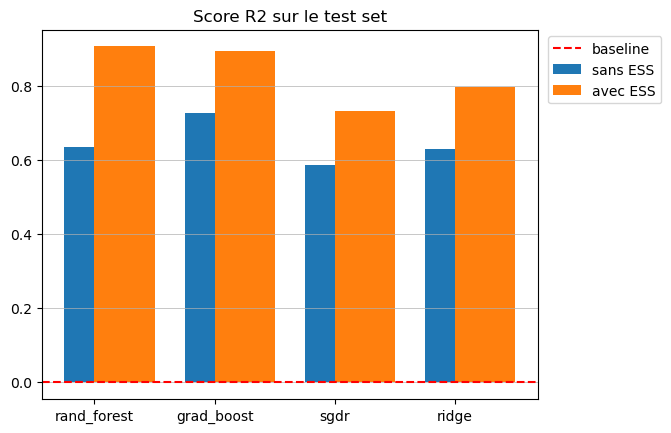

In [107]:
pos = list(range(4))
width = 0.5
plt.bar( x= comp1.columns,  height = comp1.iloc[1,:], width = width, label = 'sans ESS')
plt.bar(x= comp2.columns, height = comp2.iloc[1,:], width= width,align = 'edge',label = 'avec ESS')
plt.axhline(y=comparateur.iloc[1,0], color = 'red', linestyle='--',label='baseline')
plt.title('Score R2 sur le test set')
plt.legend(loc = (1.02,0.8))
plt.grid(axis = 'y',lw=0.5)
plt.show()

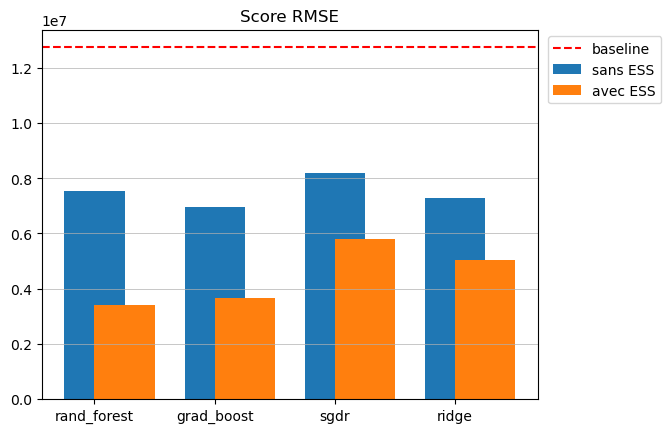

In [108]:
pos = list(range(4))
width = 0.5
plt.bar( x= comp1.columns,  height = comp1.iloc[2,:], width = width, label = 'sans ESS')
plt.bar(x= comp2.columns, height = comp2.iloc[2,:], width= width,align = 'edge',label = 'avec ESS')
plt.axhline(y=comparateur.iloc[2,0], color = 'red', linestyle='--',label='baseline')
plt.title('Score RMSE')
plt.legend(loc = (1.02,0.8))
plt.grid(axis = 'y',lw=0.5)
plt.show()

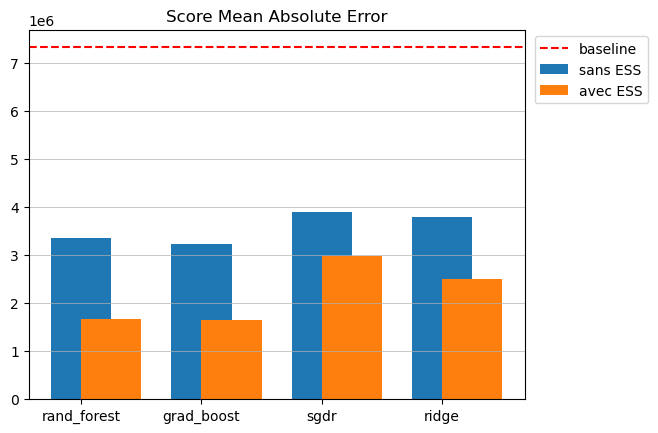

In [109]:
pos = list(range(4))
width = 0.5
plt.bar( x= comp1.columns,  height = comp1.iloc[3,:], width = width, label = 'sans ESS')
plt.bar(x= comp2.columns, height = comp2.iloc[3,:], width= width,align = 'edge',label = 'avec ESS')
plt.axhline(y=comparateur.iloc[3,0], color = 'red', linestyle='--',label='baseline')
plt.title('Score Mean Absolute Error')
plt.legend(loc = (1.02,0.8))
plt.grid(axis = 'y',lw=0.5)
plt.show()

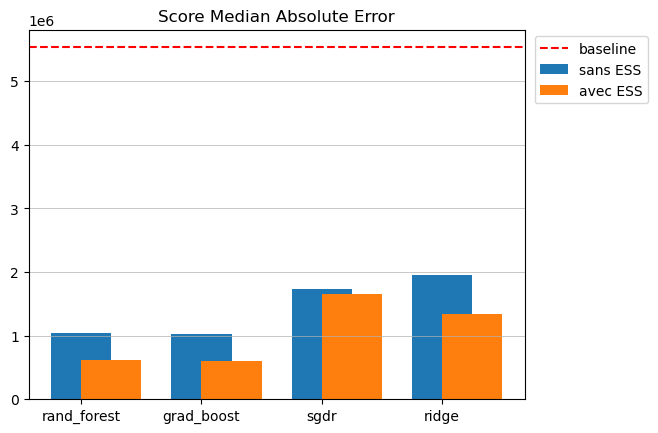

In [110]:
pos = list(range(4))
width = 0.5
plt.bar( x= comp1.columns,  height = comp1.iloc[4,:], width = width, label = 'sans ESS')
plt.bar(x= comp2.columns, height = comp2.iloc[4,:], width= width,align = 'edge',label = 'avec ESS')
plt.axhline(y=comparateur.iloc[4,0], color = 'red', linestyle='--',label='baseline')
plt.title('Score Median Absolute Error')
plt.legend(loc = (1.02,0.8))
plt.grid(axis = 'y',lw=0.5)
plt.show()

# <a name="9"> Valeurs shap

In [111]:
import shap


In [112]:
X_train_nrm = preprocessor3.fit_transform(X_train,y_train)

In [113]:
model = RandomForestRegressor(random_state = 0, criterion='poisson',n_estimators= 1000)
model.fit(X_train_nrm,y_train)

RandomForestRegressor(criterion='poisson', n_estimators=1000, random_state=0)

In [114]:
explainer = shap.explainers.Tree(model)


In [115]:
shap.initjs()

In [116]:
noms_col = preprocessor3.named_transformers_['onehotencoder'].get_feature_names_out(features_cat).tolist() + features_ord + features_num + ['SiteEnergyUse(kBtu)']

In [117]:
shap_values = explainer.shap_values(X_train_nrm[[0]])
shap.force_plot(explainer.expected_value[0], shap_values[0],
                feature_names = noms_col)

In [118]:
shap_values = explainer.shap_values(X_train_nrm[[1]])
shap.force_plot(explainer.expected_value[0], shap_values[0],
                feature_names = noms_col)

In [119]:
shap_values = explainer.shap_values(X_train_nrm[[2]])
shap.force_plot(explainer.expected_value[0], shap_values[0],
                feature_names = noms_col)